In [3]:
# 读取数据
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

# 创建一个event_accumulator对象，指定事件文件的路径
igd_ea = event_accumulator.EventAccumulator('output/train/ns_deepjs/run02_no_mask/log/events.out.tfevents.1678506790.307d8e56558d.49369.0')
igd_ea.Reload()
ppo_ea = event_accumulator.EventAccumulator('output/train/ppo/run_0/log/events.out.tfevents.1678503121.307d8e56558d.18107.0')
ppo_ea.Reload()

In [2]:
igd_ea2 = event_accumulator.EventAccumulator('output/train/ns_deepjs/run01/log/events.out.tfevents.1678505398.307d8e56558d.28778.0')
igd_ea2.Reload()

KeyboardInterrupt: 

In [ ]:
# 保存数据

# 读取数据

In [5]:
import math
def smooth(scalars: list[float], weight: float) -> list[float]:
    last = 0
    smoothed = []
    num_acc = 0
    for next_val in scalars:
        last = last * weight + (1 - weight) * next_val
        num_acc += 1
        # de-bias
        debias_weight = 1
        if weight != 1:
            debias_weight = 1 - math.pow(weight, num_acc)
        smoothed_val = last / debias_weight
        smoothed.append(smoothed_val)

    return smoothed
def get_num_score(origin, num = 11000):
    steps = []
    values = []
    for v in origin:
        if v.step <= num:
            steps.append(v.step)
            values.append(v.value)
        else:
            break
    return steps, values

In [6]:
import numpy as np
# 数据预处理
duration_max = 500/5
balance_max = 200
ppo_duration_score = ppo_ea.Scalars('mean/duration_score')
ppo_duration_step, ppo_duration_values = get_num_score(ppo_duration_score,11000)
ppo_duration_values = np.array(ppo_duration_values)/5
ppo_balance_score = ppo_ea.Scalars('mean/balance_score')
ppo_balance_step, ppo_balance_values = get_num_score(ppo_balance_score,11000)
ppo_reward = -(np.array(ppo_duration_values)/duration_max + np.array(ppo_balance_values)/balance_max) * 1200 / 2
smooth_ppo_reward = smooth(ppo_reward, 0.95)
smooth_ppo_duration_values = smooth(ppo_duration_values, 0.95)
smooth_ppo_balance_values = smooth(ppo_balance_values, 0.95)

igd_duration_score = igd_ea.Scalars('mean/duration_score')
igd_duration_step, igd_duration_values = get_num_score(igd_duration_score,11000)
igd_duration_values = np.array(igd_duration_values)/5
igd_balance_score = igd_ea.Scalars('mean/balance_score')
igd_balance_step, igd_balance_values = get_num_score(igd_balance_score,11000)
igd_reward = -(np.array(igd_duration_values)/duration_max + np.array(igd_balance_values)/balance_max) * 1200 / 2
smooth_igd_reward = smooth(igd_reward, 0.95)
smooth_igd_duration_values = smooth(igd_duration_values, 0.95)
smooth_igd_balance_values = smooth(igd_balance_values, 0.95)

In [14]:
ppo_ea.scalars.Keys()

['current/duration_score',
 'current/balance_score',
 'mean/duration_score',
 'mean/balance_score']

In [7]:
ppo_duration_score = ppo_ea.Scalars('current/duration_score')
ppo_balance_score = ppo_ea.Scalars('current/balance_score')
ppo_duration_step, ppo_duration_values = get_num_score(ppo_duration_score,50000)
ppo_balance_step, ppo_balance_values = get_num_score(ppo_balance_score,50000)

In [146]:
len(ppo_balance_step)

10000

In [58]:
f2 = np.array(ppo_duration_step)%10 == 0
ppo_duration_values = np.array(ppo_duration_values)[f2]
ppo_balance_values = np.array(ppo_balance_values)[f2]

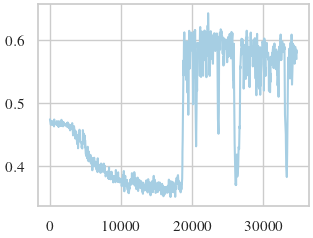

In [96]:
ppo_step = np.array(ppo_duration_step)[f2]
ppo_score = ppo_duration_values/600 * 0.5 + ppo_balance_values/250 * 0.5
plt.plot(ppo_step, ppo_score)

In [22]:
max(ppo_duration_step)

34798

In [8]:
igd_ea_duration_score = igd_ea.Scalars('current/duration_score')
igd_ea_balance_score = igd_ea.Scalars('current/balance_score')
igd_duration_step, igd_duration_values = get_num_score(igd_duration_score,50000)
igd_balance_step, igd_balance_values = get_num_score(igd_balance_score,50000)

In [9]:
def get_best_socre(duration_score, balance_score):
    best_duration_score = []
    best_balance_score = []
    best_score = []
    duration_score = np.array(duration_score)/5
    n = len(duration_score)
    for i in range(n):
        score = duration_score[i]/600*5 * 0.5 + balance_score[i]/250 * 0.5
        if i == 0:
            best_duration_score.append(duration_score[i])
            best_balance_score.append(balance_score[i])
            best_score.append(score)
        else:
            if score < best_score[-1]:
                best_duration_score.append(duration_score[i])
                best_balance_score.append(balance_score[i])
                best_score.append(score)
            else:
                best_duration_score.append(best_duration_score[-1])
                best_balance_score.append(best_balance_score[-1])
                best_score.append(best_score[-1])
    return best_duration_score, best_balance_score, best_score

In [11]:
import pandas as pd
merl_data = pd.read_csv('output/tmp/mean_score.csv')
merl_data.head()

Unnamed: 0  generation   duration   balance     score
0           0           0  479.44803  32.52327  0.464587
1           1           1  479.44803  32.52327  0.464587
2           2           2  479.44803  32.52327  0.464587
3           3           3  479.44803  32.52327  0.464587
4           4           4  483.14032  29.85212  0.462321

In [12]:
ppo_best_duration_score, ppo_best_balance_score, ppo_best_score = get_best_socre(ppo_duration_values, ppo_balance_values)
# print(len(ppo_best_score), len(ppo_duration_values), len(ppo_duration_step))
igd_best_duration_score, igd_best_balance_score, igd_best_score = get_best_socre(igd_duration_values, igd_balance_values)
merl_duration_score, merl_balance_score, merl_score = merl_data["duration"][:12001].to_list(), merl_data["balance"][:12001].to_list(), merl_data["score"][:12001].to_list() 
# merl_duration_score, merl_balance_score
merl_best_duration_score, merl_best_balance_score, merl_best_score = get_best_socre(merl_duration_score, merl_balance_score) 
# merl_best_score

erl_simulation_num = (np.array(merl_data["generation"][:12001]) * 25).tolist()
ppo_simulation_num = ppo_duration_step + [max(erl_simulation_num)]
igd_simulation_num = (np.array(igd_duration_step) * 10).tolist() + [max(erl_simulation_num)]

ppo_best_duration_score, ppo_best_balance_score, ppo_best_score = ppo_best_duration_score + [ppo_best_duration_score[-1]], ppo_best_balance_score + [ppo_best_balance_score[-1]], ppo_best_score + [ppo_best_score[-1]]
igd_best_duration_score, igd_best_balance_score, igd_best_score = igd_best_duration_score + [igd_best_duration_score[-1]], igd_best_balance_score + [igd_best_balance_score[-1]], igd_best_score + [igd_best_score[-1]]

In [47]:
max(erl_simulation_num)

300000

In [162]:
len(ppo_simulation_num), len(ppo_best_score)

(10001, 10001)

In [14]:
def get_y_by_x(x_list, y_list, x_index):
    res = []
    i = 0
    pre_y = None
    for x_i in x_index:
        for x, y in zip(x_list, y_list):
            if x == x_i:
                res.append(y)
                break
            elif x > x_i:
                res.append(pre_y)
                break
            pre_y = y
    return res

In [49]:
max(igd_simulation_num)

300000

In [50]:
x_index = np.linspace(0, 300000, 7, dtype=np.int32)
get_y_by_x(igd_simulation_num, igd_best_score, x_index)

[0.505384038289388,
 0.37068186950683596,
 0.360667246500651,
 0.3524308115641276,
 0.3524308115641276,
 0.3524308115641276,
 0.3524308115641276]

In [61]:
ppo_simulation_num[0], ppo_simulation_num[0]

(2, 2)

In [58]:
np.linspace(0, 300000, 7, dtype=np.int32)

array([     0,  50000, 100000, 150000, 200000, 250000, 300000],
      dtype=int32)

In [60]:
get_y_by_x(erl_simulation_num, merl_best_score, m_x)

[0.464586565,
 0.355586935,
 0.33353794499999995,
 0.33067749333333335,
 0.32308733166666664,
 0.31701436,
 0.31211478666666664]

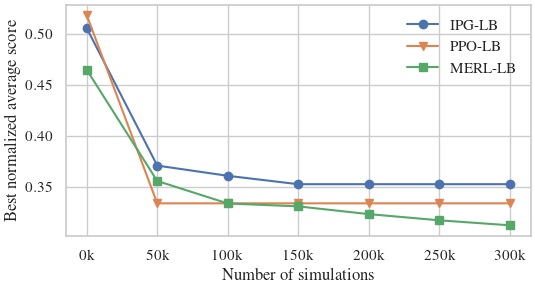

In [63]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scienceplots
plt.style.use('science')
sns.set()
sns.set_theme(style="whitegrid")
sns.color_palette("tab10")
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times"]})

def format_int_func(x, pos):
    return f"{int(x/1000)}k"

int_formatter = ticker.FuncFormatter(format_int_func)


m_x = np.linspace(0, 300000, 7, dtype=np.int32)
y1 = get_y_by_x(igd_simulation_num, igd_best_score, m_x)
ppo_simulation_num[0] = 0
y2 = get_y_by_x(ppo_simulation_num, ppo_best_score, m_x)
y3 = get_y_by_x(erl_simulation_num, merl_best_score, m_x)
# plt.plot(m_x, y1, marker='o')
# plt.plot(m_x, y2, marker='o')
# plt.plot(m_x, y3, marker='o')

plt.figure(figsize=(6,3))
plt.subplot(1,1,1)
# plt.plot(igd_simulation_num, igd_best_score, label = 'IPG-LB')
# plt.plot(ppo_simulation_num, ppo_best_score, label = 'PPO-LB')
# plt.plot(erl_simulation_num, merl_best_score, label = 'MERL-LB')
plt.plot(m_x, y1, marker='o', label = 'IPG-LB')
plt.plot(m_x, y2, marker='v', label = 'PPO-LB')
plt.plot(m_x, y3, marker='s', label = 'MERL-LB')
plt.gca().xaxis.set_major_formatter(int_formatter)
plt.xlabel('Number of simulations')
plt.ylabel('Best normalized average score')
# plt.title('Best normalized weighted average score',fontsize=14)
plt.legend()

# plt.subplot(1,3,2)
# plt.plot(ppo_simulation_num, ppo_best_duration_score, label = 'PPO-LB')
# plt.plot(igd_simulation_num, igd_best_duration_score, label = 'DeepJS-LB')
# plt.plot(erl_simulation_num, merl_best_duration_score, label = 'MERL-LB')
# plt.gca().xaxis.set_major_formatter(int_formatter)
# plt.xlabel('Number of simulations')
# plt.ylabel('Idle score (minutes)')
# plt.title('(b) Idel Score',fontsize=14)
# plt.legend()

# plt.subplot(1,3,3)
# plt.plot(ppo_simulation_num, ppo_best_balance_score, label = 'PPO-LB')
# plt.plot(igd_simulation_num, igd_best_balance_score, label = 'DeepJS-LB')
# plt.plot(erl_simulation_num, merl_best_balance_score, label = 'MERL-LB')
# plt.gca().xaxis.set_major_formatter(int_formatter)
# plt.xlabel('Number of simulations')
# plt.ylabel('Balance score (units)')
# plt.title('(c) Balance Score',fontsize=14)
# plt.legend()

# plot marker
# m_x = np.linspace(0, 300000, 7, dtype=np.int32)
# y1 = get_y_by_x(igd_simulation_num, igd_best_score, m_x)
# y2 = get_y_by_x(ppo_simulation_num, ppo_best_score, m_x)
# y3 = get_y_by_x(erl_simulation_num, merl_best_score, m_x)
# plt.plot(m_x, y1, marker='o')
# plt.plot(m_x, y2, marker='o')
# plt.plot(m_x, y3, marker='o')

plt.savefig('3-模拟次数对比.pdf', dpi=300, bbox_inches = 'tight')

In [33]:
np.linspace(0, 300000, 7, dtype=np.int32)

array([     0,  50000, 100000, 150000, 200000, 250000, 300000],
      dtype=int32)

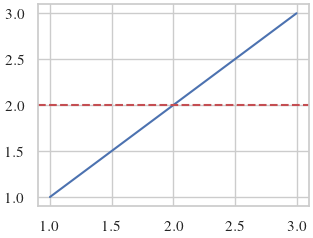

In [53]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot([1, 2, 3], [1, 2, 3])

ax.axhline(y=2, color='r', linestyle='--')

plt.show()

In [ ]:
max_erl_step = np.array(erl_step[:12500])*25
max_erl_score = get_scores_min(erl_score[:12500])
max_step = max(max_erl_step)
max_ppo_step = list(ppo_step) + [max_step]
max_igd_step = list(igd_step * 10) + [max_step]
max_ppo_score = get_scores_min(ppo_score)
max_ppo_score = max_ppo_score + [min(max_ppo_score)]
max_igd_score = get_scores_min(igd_score)
max_igd_score = max_igd_score + [min(max_igd_score)]

In [53]:
f1 = np.array(igd_duration_step)%10 == 0

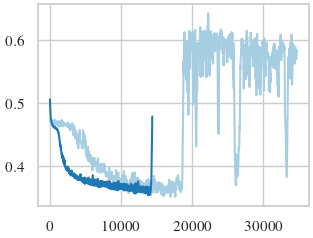

In [97]:
igd_step = np.array(igd_duration_step)[f1]
igd_score = igd_duration_values/600 * 0.5 + igd_balance_values/250 * 0.5
plt.plot(ppo_step, ppo_score)
plt.plot(igd_step, igd_score)

In [98]:
import pandas as pd
data = pd.read_csv('output/tmp/mean_score.csv')
data.head()

generation   duration   balance     score
0           0  269.35108  32.52327  0.464587
1           1  267.31281  32.52327  0.464587
2           2  266.62119  30.04290  0.464587
3           3  266.62119  22.86407  0.464587
4           4  266.62119  22.86407  0.462321

In [93]:
data['score'] = data['duration']/5 * 0.5

In [100]:
erl_step = data['generation'].to_numpy()
erl_score = data['score'].to_numpy()

In [80]:
len(erl_score)

51774

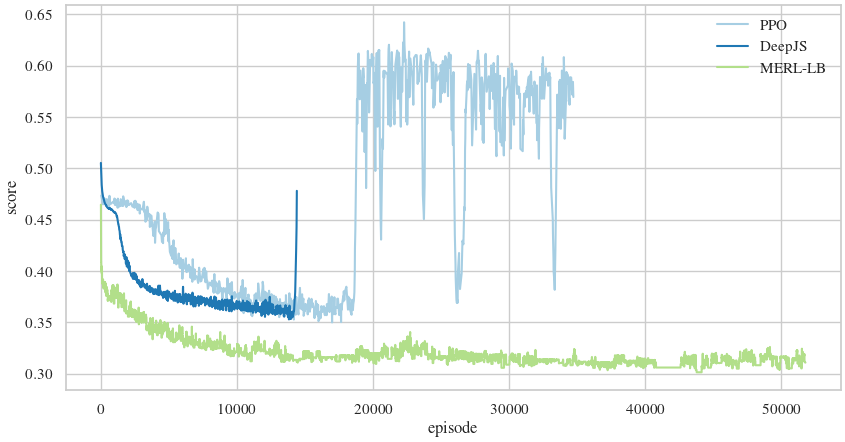

In [101]:
plt.figure(figsize=(10,5))
plt.plot(ppo_step, ppo_score, label = 'PPO')
plt.plot(np.array(igd_step), igd_score, label = 'DeepJS')
plt.plot(np.array(erl_step), erl_score, label = 'MERL-LB')
plt.xlabel('episode')
plt.ylabel('score')
plt.legend()

In [105]:
def get_scores_min(scores):
    cumulative_scores_min = []
    for s in scores:
        if cumulative_scores_min == []:
            cumulative_scores_min.append(s)
        else:
            cumulative_scores_min.append(min(s, cumulative_scores_min[-1]))
    return cumulative_scores_min

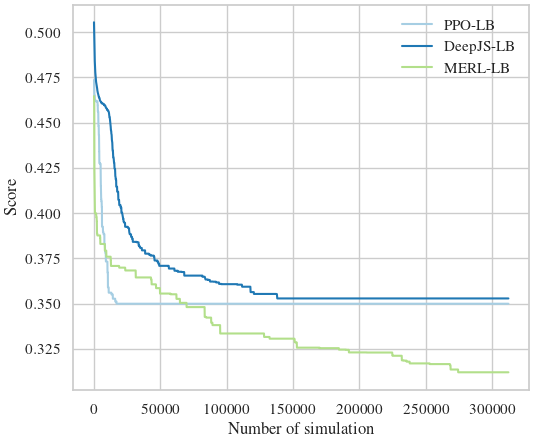

In [123]:
max_erl_step = np.array(erl_step[:12500])*25
max_erl_score = get_scores_min(erl_score[:12500])
max_step = max(max_erl_step)
max_ppo_step = list(ppo_step) + [max_step]
max_igd_step = list(igd_step * 10) + [max_step]
max_ppo_score = get_scores_min(ppo_score)
max_ppo_score = max_ppo_score + [min(max_ppo_score)]
max_igd_score = get_scores_min(igd_score)
max_igd_score = max_igd_score + [min(max_igd_score)]


plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.plot(max_ppo_step, max_ppo_score, label = 'PPO-LB')
plt.plot(max_igd_step, max_igd_score, label = 'DeepJS-LB')
plt.plot(max_erl_step, max_erl_score, label = 'MERL-LB')
plt.xlabel('Number of simulation')
plt.ylabel('Score')
plt.legend()

In [54]:
igd_duration_values = np.array(igd_duration_values)[f1]

In [57]:
igd_balance_values = np.array(igd_balance_values)[f1]

In [24]:
max(igd_duration_step)

14435

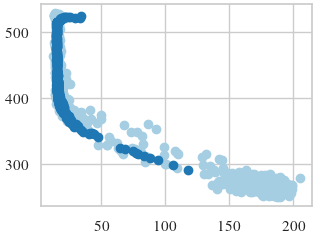

In [59]:
plt.scatter(ppo_balance_values, ppo_duration_values)
plt.scatter(igd_balance_values, igd_duration_values)

In [46]:
a = np.load('output/train/nei_nsga/g30000_0/mean_fitness_record.npy')
x1 = -a[:,2]/5
y1 = -a[:,3]
x1, y1

(array([88.7625624 , 42.44685524, 62.38329451, 79.32083195, 84.04019967,
        68.48928453, 47.16146423, 66.15061564, 63.47574043, 59.53643927,
        45.91301165, 74.69973378, 43.75630616, 51.14269551, 71.91590682,
        49.40801997, 52.52821963, 55.95986689, 55.45710483, 59.2968386 ,
        54.25797005, 44.84955075, 57.17500832, 52.96968386, 50.33853577]),
 array([ 11.55493821, 182.24359896,  46.26654027,  12.70454496,
         12.2747235 ,  22.0105581 , 140.65198869,  30.32614378,
         33.55407551,  56.23943691, 152.86554957,  13.91609899,
        174.13750886, 118.5899354 ,  18.66082693, 135.519496  ,
        114.82934356,  81.05267239,  91.40443069,  63.5058582 ,
         94.86738986, 164.27780184,  77.35331984, 104.87159434,
        128.55043833]))

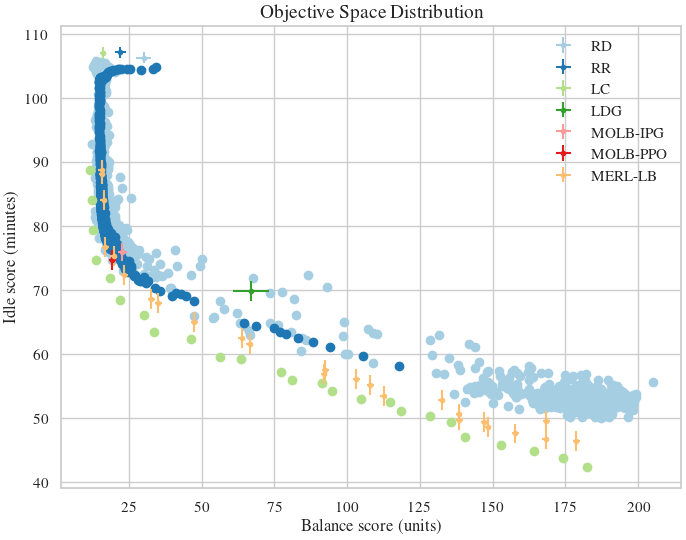

In [60]:
# 总览图
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scienceplots
plt.style.use('science')
sns.set()
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times"]})

save_path = {
    'RD':'output/test/rd/run01',
    'RR':'output/test/rr/run01',
    'LC':'output/test/lc/run01',
    'LDG':'output/test/lg/run01',
    'MOLB-IPG':'output/test/igd/best_run01',
    'MOLB-PPO':'output/test/ppo/best_run01',
}

df_dic = {}
for key, save_path in save_path.items():
    df = pd.read_csv(os.path.join(save_path, 'mean_std.csv'))
    df = df.drop(columns=['Unnamed: 0'])
    df_dic[key] = df
df_dic

# sns.color_palette("Paired")
sns.set_palette("Paired")
data = []
plt.figure(figsize=(8,6))

plt.scatter(ppo_balance_values, np.array(ppo_duration_values)/5)
plt.scatter(igd_balance_values, np.array(igd_duration_values)/5)

for key, df in df_dic.items():
    data.append((key, df['balance_fitness_mean'][0], df['duration_fitness_mean'][0]/5, df['balance_fitness_std'][0], df['duration_fitness_std'][0]/5))
    plt.errorbar(df['balance_fitness_mean'][0], df['duration_fitness_mean'][0]/5, xerr=df['balance_fitness_std'][0], yerr=df['duration_fitness_std'][0]/5, label=key, fmt='.')
df = pd.DataFrame(data, columns=['methods', 'balance_score', 'idle_score','balance_std', 'idle_std'])

nsga_df = pd.read_csv('output/test/nei_nsga/nsga_nei_run01_g30000_0/mean_std.csv')
nsga_df = nsga_df.drop(columns=['Unnamed: 0'])
plt.errorbar(nsga_df['balance_fitness_mean'], nsga_df['duration_fitness_mean']/5,xerr=nsga_df['balance_fitness_std'][0], yerr=nsga_df['duration_fitness_std'][0]/5,  label='MERL-LB', fmt='.')

plt.scatter(y1, x1)


plt.legend()
# plt.xlim(10,190)
# plt.ylim(40,110)
plt.xlabel("Balance score (units)")
plt.ylabel("Idle score (minutes)")
plt.title("Objective Space Distribution",fontsize=14)
plt.savefig('2-目标空间分布2.pdf', dpi=300, bbox_inches = 'tight')

In [36]:
# 上界 250
# 下界 0
a = [0] * 10 + [500] * 10
500


500

In [37]:
np.std(a)

250.0

In [17]:
# 上界 500
# 下界 250

[ScalarEvent(wall_time=1678503149.4347339, step=2, value=526.0607299804688),
 ScalarEvent(wall_time=1678503172.640036, step=5, value=527.779541015625),
 ScalarEvent(wall_time=1678503190.7127705, step=7, value=516.0233154296875),
 ScalarEvent(wall_time=1678503255.4711409, step=15, value=522.2903442382812),
 ScalarEvent(wall_time=1678503263.2567656, step=16, value=525.7813720703125),
 ScalarEvent(wall_time=1678503303.9905152, step=21, value=533.3560791015625),
 ScalarEvent(wall_time=1678503311.920573, step=22, value=528.7188110351562),
 ScalarEvent(wall_time=1678503319.3998654, step=23, value=517.659912109375),
 ScalarEvent(wall_time=1678503362.8354206, step=28, value=519.3196411132812),
 ScalarEvent(wall_time=1678503379.7874808, step=30, value=520.0306396484375),
 ScalarEvent(wall_time=1678503435.5758004, step=37, value=520.0354614257812),
 ScalarEvent(wall_time=1678503451.7939875, step=39, value=521.8860473632812),
 ScalarEvent(wall_time=1678503477.1188242, step=42, value=531.424987792

In [5]:
np.argmax(igd_reward),np.argmax(ppo_reward)

(7513, 2993)

In [6]:
igd_ea.Scalars('mean/duration_score')[9593]

ScalarEvent(wall_time=1678968710.9976254, step=13819, value=366.3871154785156)

In [7]:
ppo_ea.Scalars('mean/duration_score')[4792]

ScalarEvent(wall_time=1678691025.9291182, step=16679, value=376.14447021484375)

In [8]:
max(igd_reward),max(ppo_reward)

(-519.0103008270263, -527.6872833251953)

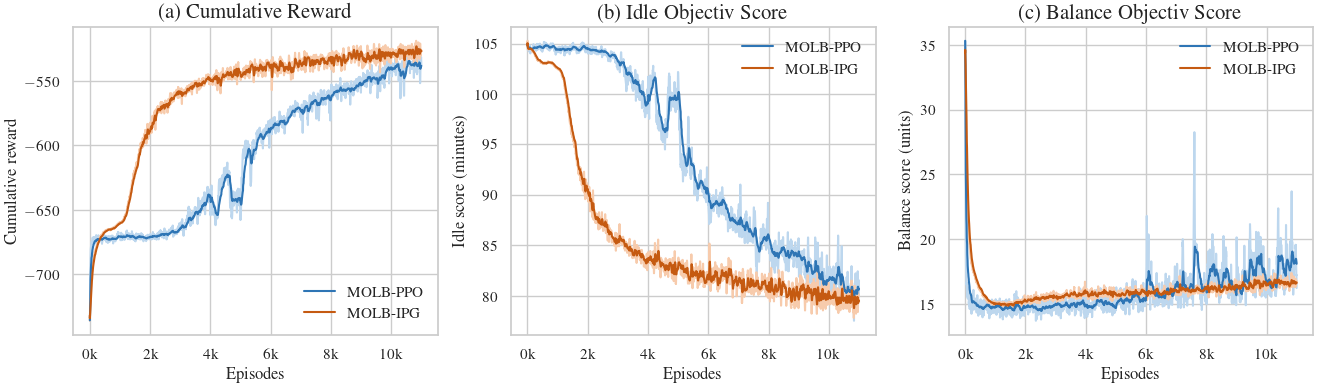

In [9]:
# 收敛性分析
# reward + 目标1 + 目标2
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scienceplots
plt.style.use('science')
sns.set()
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times"]})

# 定义一个函数，将刻度值除以1000，并加上k的后缀
def format_func(x, pos):
    return f"{x/1000}k"

def format_int_func(x, pos):
    return f"{int(x/1000)}k"

# 创建一个格式器对象
formatter = ticker.FuncFormatter(format_func)
int_formatter = ticker.FuncFormatter(format_int_func)

plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.plot(ppo_duration_step, ppo_reward, c='#bdd7ee')
plt.plot(igd_duration_step, igd_reward, c='#f7cbac')
plt.plot(ppo_duration_step, smooth_ppo_reward, c='#2e75b5', label='MOLB-PPO')
plt.plot(igd_duration_step, smooth_igd_reward, c='#c55a11', label='MOLB-IPG')
# 将格式器应用到x轴上
# plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().xaxis.set_major_formatter(int_formatter)
plt.title('(a) Cumulative Reward',fontsize=15)
plt.ylabel('Cumulative reward')
plt.xlabel('Episodes')
plt.legend()

plt.subplot(1,3,2)
plt.plot(ppo_duration_step, ppo_duration_values, c='#bdd7ee')
plt.plot(igd_duration_step, igd_duration_values, c='#f7cbac')
plt.plot(ppo_duration_step, smooth_ppo_duration_values, c='#2e75b5', label='MOLB-PPO')
plt.plot(igd_duration_step, smooth_igd_duration_values, c='#c55a11', label='MOLB-IPG')
# 将格式器应用到x轴上
plt.gca().xaxis.set_major_formatter(int_formatter)
plt.title('(b) Idle Objectiv Score',fontsize=15)
plt.ylabel('Idle score (minutes)')
plt.xlabel('Episodes')
plt.legend()


plt.subplot(1,3,3)
plt.plot(ppo_balance_step, ppo_balance_values, c='#bdd7ee')
plt.plot(igd_balance_step, igd_balance_values, c='#f7cbac')
plt.plot(ppo_balance_step, smooth_ppo_balance_values, c='#2e75b5', label='MOLB-PPO')
plt.plot(igd_balance_step, smooth_igd_balance_values, c='#c55a11', label='MOLB-IPG')
# 将格式器应用到x轴上
plt.gca().xaxis.set_major_formatter(int_formatter)
plt.title('(c) Balance Objectiv Score',fontsize=15)
plt.ylabel('Balance score (units)')
plt.xlabel('Episodes')
plt.legend()

plt.savefig('强化学习训练收敛过程.pdf', dpi=300, bbox_inches = 'tight')

In [2]:
# 总览图
import pandas as pd
import os
from matplotlib.pyplot import MultipleLocator
save_path = {
    'RD':'output/test/rd/run01',
    'RR':'output/test/rr/run01',
    'LC':'output/test/lc/run01',
    'LDG':'output/test/lg/run01',
    'MOLB-PPO':'output/test/igd/best_run01',
    'MOLB-IPG':'output/test/ppo/best_run01',
    # 'MOLB-IPG':'output/test/igd/best_run01',
    # 'MOLB-PPO':'output/test/ppo/best_run01',
}
# save_path = {
#     'RD':'output/test/rd/run01',
#     'RR':'output/test/rr/run01',
#     'LC':'output/test/lc/run01',
#     'LDG':'output/test/lg/run01',
#     'MOLB-PPO':'output/test/ppo/run02',
#     'MOLB-IPG':'output/test/deepjs/ns_run01',
# }

df_dic = {}
for key, save_path in save_path.items():
    df = pd.read_csv(os.path.join(save_path, 'mean_std.csv'))
    df = df.drop(columns=['Unnamed: 0'])
    df_dic[key] = df
df_dic

# sns.color_palette("Paired")
sns.set_palette("Paired")
data = []
plt.figure(figsize=(8,6))
for key, df in df_dic.items():
    data.append((key, df['balance_fitness_mean'][0], df['duration_fitness_mean'][0]/5, df['balance_fitness_std'][0], df['duration_fitness_std'][0]/5))
    plt.errorbar(df['balance_fitness_mean'][0], df['duration_fitness_mean'][0]/5, xerr=df['balance_fitness_std'][0], yerr=df['duration_fitness_std'][0]/5, label=key, fmt='o')
df = pd.DataFrame(data, columns=['methods', 'balance_score', 'idle_score','balance_std', 'idle_std'])
df.to_csv('output/tmp/ch4_mean_std.csv')
plt.legend()
# y_major_locator=MultipleLocator(10)
# ax=plt.gca()
# ax.yaxis.set_major_locator(y_major_locator)
plt.xlim(10,80)
plt.ylim(60,120)
plt.xlabel("Balance score (units)")
plt.ylabel("Idle score (minutes)")
plt.title("Objective Space Distribution",fontsize=14)
plt.savefig('2-目标空间分布1.pdf', dpi=300, bbox_inches = 'tight')

NameError: name 'sns' is not defined

In [239]:
a = [1000, 0]
np.std(a)

500.0

In [240]:
a = [1000/5, 0]
np.std(a)

100.0

In [5]:
import os
import numpy as np
# 负载影响
save_path = {
    'RD':'output/test/rd/user_load_run01',
    'RR':'output/test/rr/user_load_run01',
    'LC':'output/test/lc/user_load_run01',
    'LDG':'output/test/lg/user_load_run01',
    'MOLB-PPO':'output/test/igd/user_load_run01',
    'MOLB-IPG':'output/test/ppo/user_load_run01',
}
load_list = [0.300,0.450,0.600,0.750,0.900,1.050]

def get_all_rate(path, num=50):
    data = []
    for i in range(num):
        file_path = os.path.join(path, f'occupancy_rate_{i}.npy')
        data.append(np.load(file_path))
    return np.array(data)

data = []
for key, item_path in save_path.items():
    item_date = []
    for load in load_list:
        final_path = f'{item_path}/user_load_rate_{load:.3f}/data'
        item_date.append(get_all_rate(final_path))
    data.append(item_date)

# for item in data:
#     print(np.array)

/tmp/ipykernel_49396/735943920.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [8]:
import pandas as pd
# 负载影响
save_path = {
    'RD':'output/test/rd/user_load_run01',
    'RR':'output/test/rr/user_load_run01',
    'LC':'output/test/lc/user_load_run01',
    'LDG':'output/test/lg/user_load_run01',
    'MOLB-PPO':'output/test/ppo/user_load_run01',
    'MOLB-IPG':'output/test/igd/user_load_run01',
}
load_list = [0.300,0.450,0.600,0.750,0.900,1.050]
score_list = ['CPU', 'RAM', 'HDD', 'BW']

def get_all_rate(path, num=50):
    data = []
    for i in range(num):
        file_path = os.path.join(path, f'occupancy_rate_{i}.npy')
        data.append(np.load(file_path))
    return np.array(data)

data = []
for key, item_path in save_path.items():
    for load in load_list:
        final_path = f'{item_path}/user_load_rate_{load:.3f}/data'
        item_data = get_all_rate(final_path)
        for j, score_type in enumerate(score_list):
            _score = []
            for item in item_data:
                item_score = np.array(item)[:,:,j] * 500
                item_score = np.mean(np.std(item_score, axis=-1), axis=-1)
                _score.append(item_score)
            _method = [key] * len(_score)
            _load = [int(load*100)] * len(_score)
            _score_type = [score_type] * len(_score)
            _item_data = zip(_method, _load, _score_type,  _score)
            _item_df = pd.DataFrame(_item_data, columns=['Method', 'Average load',  'Score type', 'Score'])
            data.append(_item_df)

df = pd.concat(data, axis=0)

/tmp/ipykernel_49396/2700662305.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)
/tmp/ipykernel_49396/2700662305.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)
/tmp/ipykernel_49396/2700662305.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)
/tmp/ipykerne

In [9]:
# 负载影响
save_path = {
    'RD':'output/test/rd/user_load_run01',
    'RR':'output/test/rr/user_load_run01',
    'LC':'output/test/lc/user_load_run01',
    'LDG':'output/test/lg/user_load_run01',
    'MOLB-PPO':'output/test/ppo/user_load_run01',
    'MOLB-IPG':'output/test/igd/user_load_run01',
}
load_list = [0.300,0.450,0.600,0.750,0.900,1.050]

def get_all_rate(path, num=50):
    data = []
    for i in range(num):
        file_path = os.path.join(path, f'occupancy_rate_{i}.npy')
        data.append(np.load(file_path))
    return np.array(data)

data = []
for key, item_path in save_path.items():
    for load in load_list:
        final_path = f'{item_path}/user_load_rate_{load:.3f}/data'
        item_data = get_all_rate(final_path)

        _score = []
        for item in item_data:
            item_score = np.array(item) * 500
            item_score = np.mean(np.std(item_score, axis=-2))
            _score.append(item_score)
        _method = [key] * len(_score)
        _load = [int(load*100)] * len(_score)
        _item_data = zip(_method, _load,  _score)
        _item_df = pd.DataFrame(_item_data, columns=['Method', 'Average load', 'Score'])
        data.append(_item_df)

df3 = pd.concat(data, axis=0)

/tmp/ipykernel_49396/35018468.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)
/tmp/ipykernel_49396/35018468.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)
/tmp/ipykernel_49396/35018468.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)
/tmp/ipykernel_4939

In [162]:

# _df=df.groupby(["Method", "Average load"]).mean()
# _df.reset_index(inplace=True)
# _df

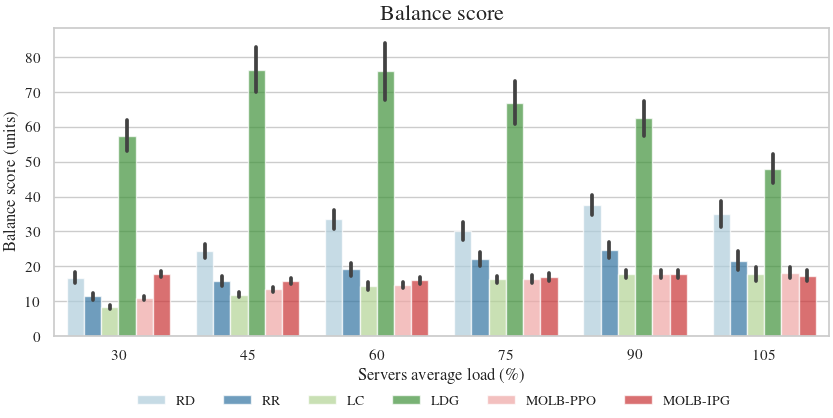

In [10]:

plt.figure(figsize=(10, 4))
ax = plt.subplot(1, 1, 1)
sns.barplot(
    data=df3, 
    x="Average load", y="Score", hue="Method",
    errorbar="sd", alpha=0.7, palette="Paired", ax = ax
)
plt.ylabel('Balance score (units)')
plt.xlabel('Servers average load (\%)')
# plt.subplots_adjust(hspace=0.4, wspace=0.1)
plt.title(f'Balance score', fontsize = 16)
plt.legend(loc=(0.1, -0.25), ncol=6, prop={'size': 10})
plt.savefig('平均均衡随负载变化图.pdf', dpi=300, bbox_inches = 'tight')

In [165]:
df.head()

Method  Average load Score type      Score
0     RD           0.3        CPU  14.849527
1     RD           0.3        CPU  16.414376
2     RD           0.3        CPU  20.020251
3     RD           0.3        CPU  18.456059
4     RD           0.3        CPU  14.761476

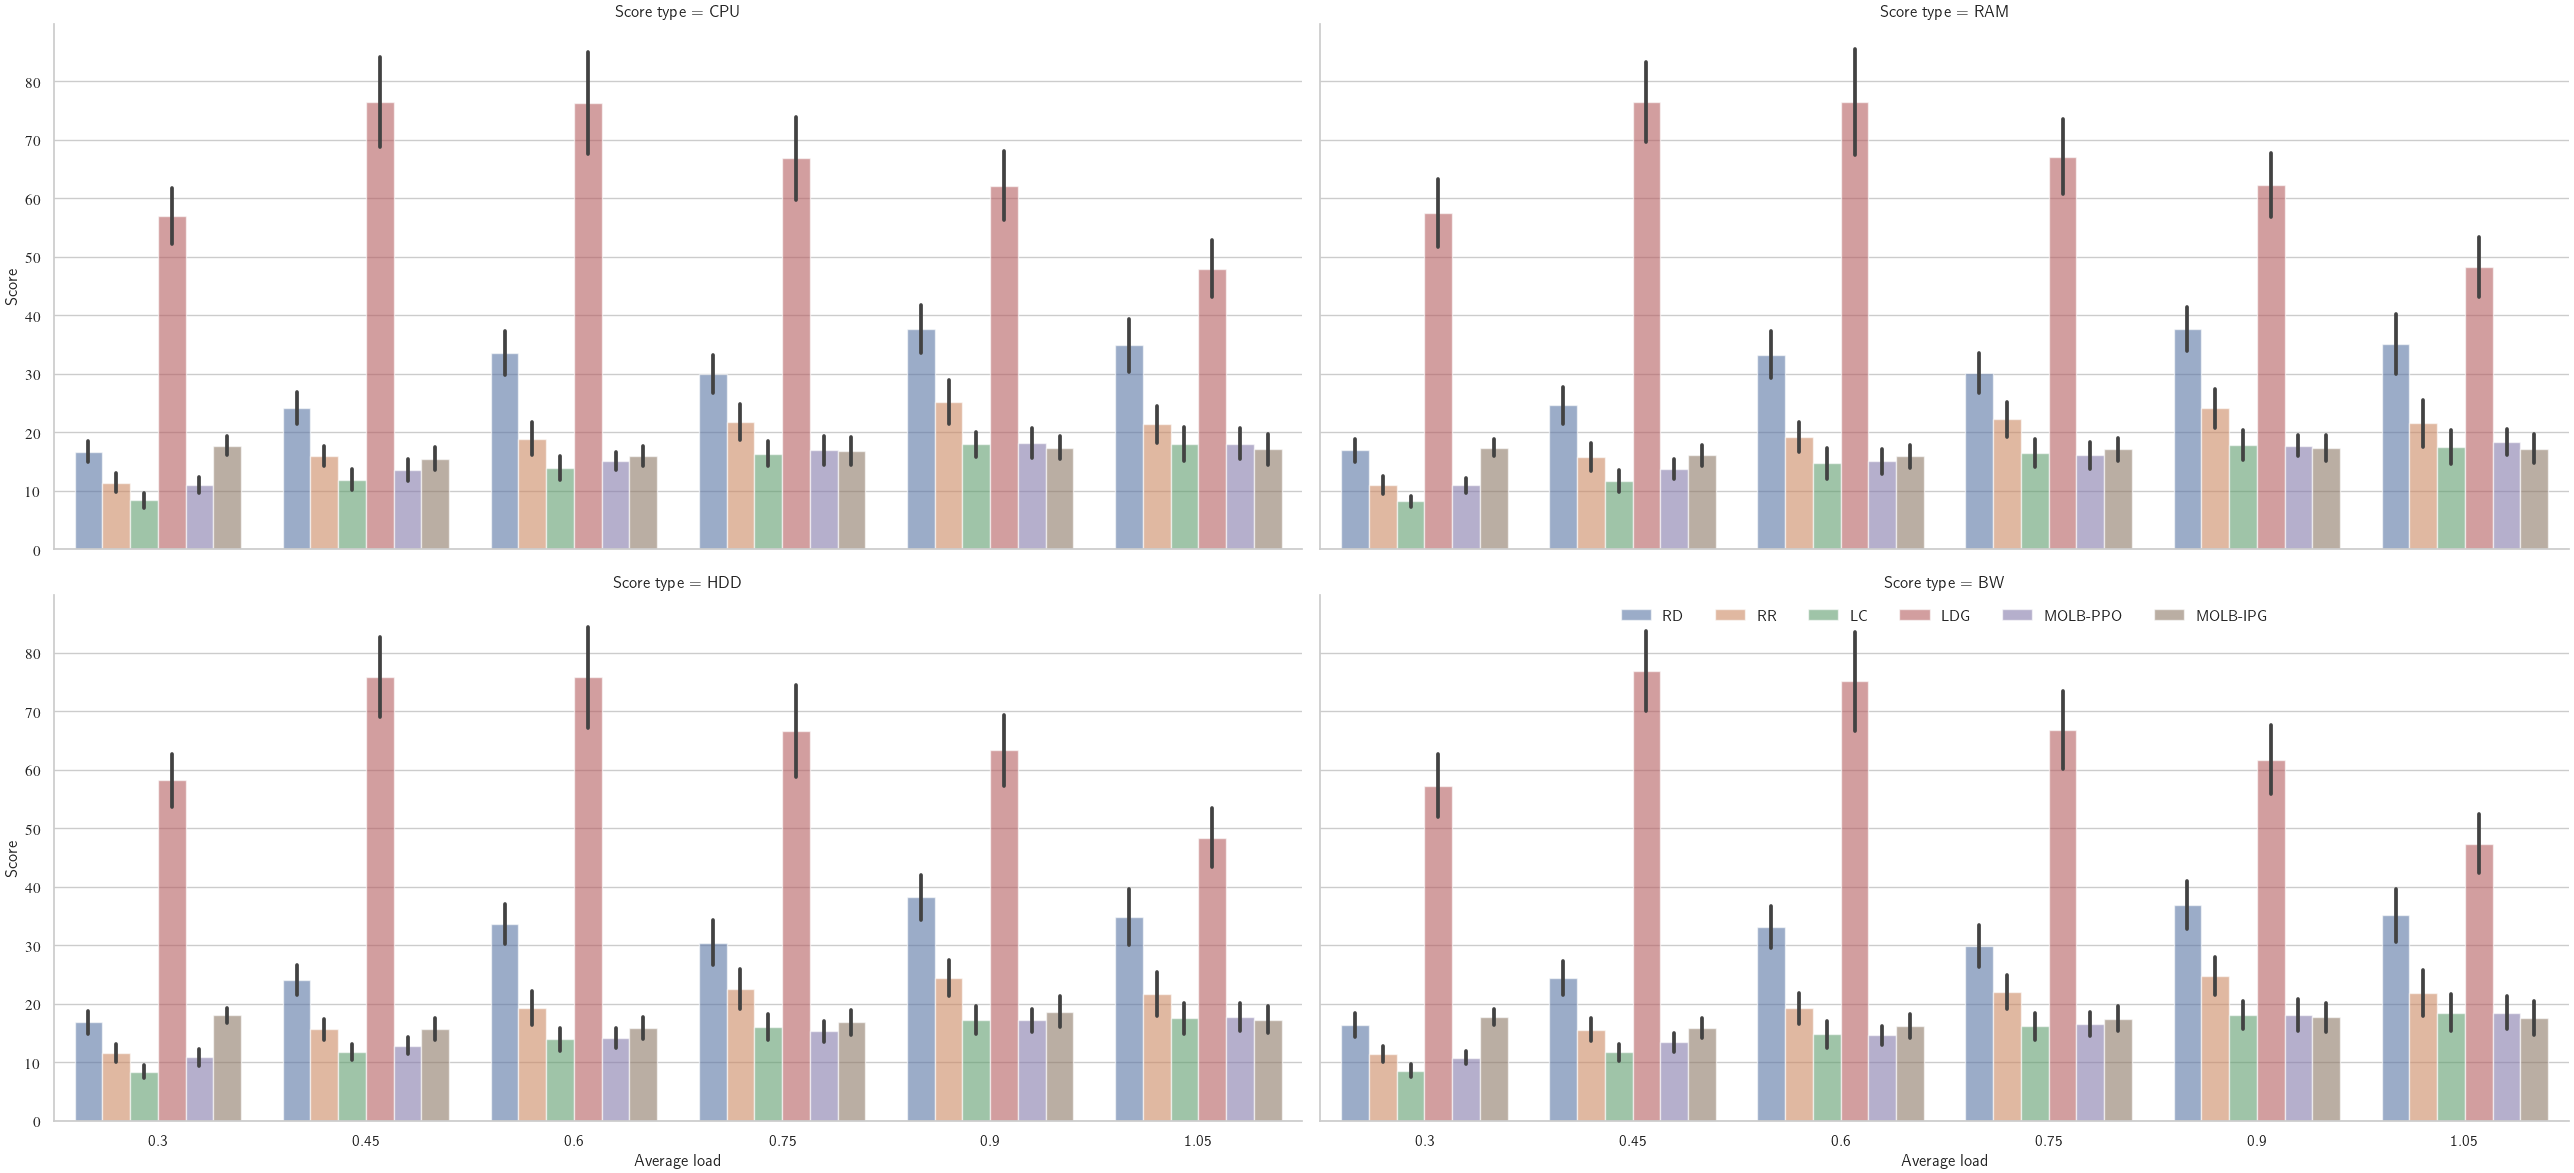

In [164]:
# plt.figure(figsize=(12, 6))
sns.catplot(
    data=df, kind="bar",
    x="Average load", y="Score", hue="Method",col='Score type', col_wrap=2,
    errorbar="sd", alpha=0.6, height=6, aspect=13/6, legend_out=False, legend=False
)
plt.legend(loc='upper center', ncol=len(df.columns) + 2)
# g = sns.FacetGrid(df, col="Score type", height=4)
# g.map(sns.barplot, x="Average load", y="Score", hue="Method",)
plt.savefig('负载变化图.pdf', dpi=300, bbox_inches = 'tight')

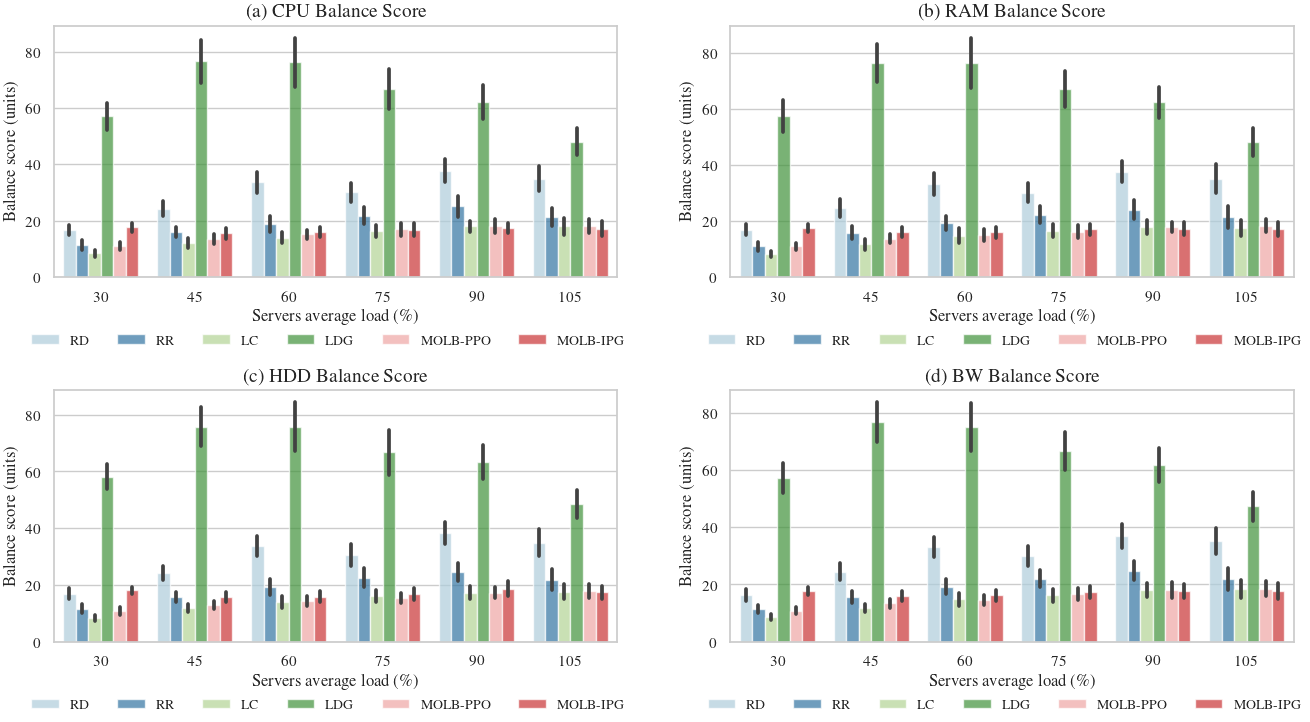

In [11]:
plt.figure(figsize=(16, 8))
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times"]})
dfs = [df[df['Score type'] == name] for name in score_list]
gindex = ['a', 'b', 'c', 'd']
for idx, temp_df in enumerate(dfs):
    ax = plt.subplot(2, 2, idx + 1)
    sns.barplot(
        data=temp_df, 
        x="Average load", y="Score", hue="Method",
        errorbar="sd", alpha=0.7, ax=ax, palette="Paired"
    )
    plt.ylabel('Balance score (units)')
    plt.xlabel('Servers average load (\%)')
    plt.subplots_adjust(hspace=0.45, wspace=0.2)
    plt.title(f'({gindex[idx]}) {score_list[idx]} Balance Score', fontsize = 14)
    plt.legend(loc=(-0.05, -0.3), ncol=6, prop={'size': 10})
plt.savefig('各资源均衡随负载变化图.pdf', dpi=300, bbox_inches = 'tight')

In [122]:
# _data = np.array(data[0][0])[:,:,:,0] * 500
# _data = np.mean(np.std(_data, axis=-1), axis=-1)
# method = ['RR'] * 50
# load = [0.300] * 50
# score_type = ["CUP balance score"] * 50
# _data = zip(method, load, score_type,  _data)
# df = pd.DataFrame(_data, columns=['Method', 'Average load',  'Score type', 'Score'])
# df

In [12]:
# 负载影响
save_path = {
    'RD':'output/test/rd/user_load_run01',
    'RR':'output/test/rr/user_load_run01',
    'LC':'output/test/lc/user_load_run01',
    'LDG':'output/test/lg/user_load_run01',
    'MOLB-PPO':'output/test/ppo/user_load_run01',
    'MOLB-IPG':'output/test/igd/user_load_run01',
}
load_list = [0.300,0.450,0.600,0.750,0.900,1.050]
score_list = ['CPU', 'RAM', 'HDD', 'BW']

def get_finish(path, num=50):
    data = []
    for i in range(num):
        file_path = os.path.join(path, f'finish_time_{i}.npy')
        data.append(np.load(file_path))
    return np.array(data)

data = []
for key, item_path in save_path.items():
    for load in load_list:
        final_path = f'{item_path}/user_load_rate_{load:.3f}/data'
        item_data = get_finish(final_path)
        _score = []
        for item in item_data:
            item_score = np.array(item)
            item_score = np.mean(item_score)
            _score.append(item_score/5)
        _method = [key] * len(_score)
        _load = [int(load*100)] * len(_score)
        _score_type = ['Idle'] * len(_score)
        _item_data = zip(_method, _load, _score_type,  _score)
        _item_df = pd.DataFrame(_item_data, columns=['Method', 'Average load',  'Score type', 'Score'])
        data.append(_item_df)

df2 = pd.concat(data, axis=0)
df2

/tmp/ipykernel_49396/4033892362.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)
/tmp/ipykernel_49396/4033892362.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)
/tmp/ipykernel_49396/4033892362.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)
/tmp/ipykerne

Method  Average load Score type      Score
0         RD            30       Idle  90.014043
1         RD            30       Idle  87.013810
2         RD            30       Idle  91.784226
3         RD            30       Idle  81.764060
4         RD            30       Idle  86.983394
..       ...           ...        ...        ...
45  MOLB-IPG           105       Idle  83.952812
46  MOLB-IPG           105       Idle  88.245621
47  MOLB-IPG           105       Idle  82.780666
48  MOLB-IPG           105       Idle  86.811928
49  MOLB-IPG           105       Idle  87.055408

[1800 rows x 4 columns]

Score
Method   Average load Score type            
LC       30           Idle         90.775064
         45           Idle        100.320491
         60           Idle        104.616862
         75           Idle        106.984172
         90           Idle        108.799050
         105          Idle        110.027685
LDG      30           Idle         36.527098
         45           Idle         51.343187
         60           Idle         61.999241
         75           Idle         69.902415
         90           Idle         75.437582
         105          Idle         82.499491
MOLB-IPG 30           Idle         59.236849
         45           Idle         70.880051
         60           Idle         76.829031
         75           Idle         79.753591
         90           Idle         82.678192
         105          Idle         87.637675
MOLB-PPO 30           Idle         67.229501
         45           Idle         74.239818
         60           Idle         77.899236
         75           Idle         80.669059
         90           Idle         82.935826
         105          Idle         87.589029
RD       30           Idle         88.723224
         45           Idle         99.335773
         60           Idle        103.802314
         75           Idle        106.264011
         90           Idle        108.237463
         105          Idle        109.367053
RR       30           Idle         90.957479
         45           Idle        100.282854
         60           Idle        104.588739
         75           Idle        107.118184
         90           Idle        108.786063
         105          Idle        109.954064

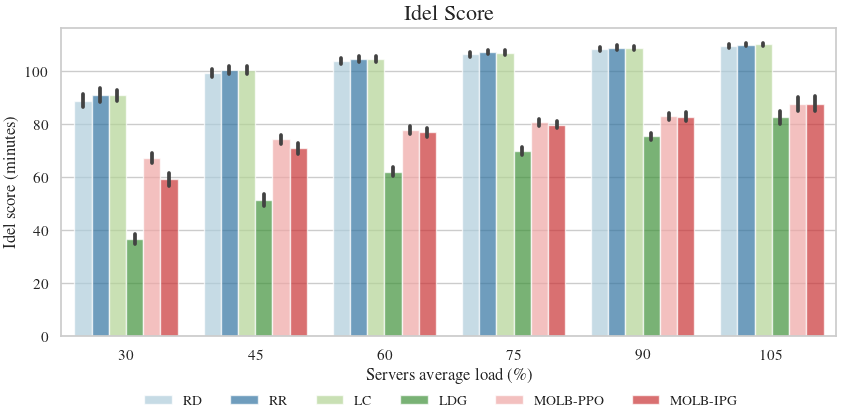

In [13]:
plt.figure(figsize=(10, 4))
ax = plt.subplot(1, 1, 1)
sns.barplot(
    data=df2, 
    x="Average load", y="Score", hue="Method",
    errorbar="sd", alpha=0.7, palette="Paired", ax = ax
)
plt.ylabel('Idel score (minutes)')
plt.xlabel('Servers average load (\%)')
# plt.subplots_adjust(hspace=0.4, wspace=0.1)
plt.title(f'Idel Score', fontsize = 16)
plt.legend(loc=(0.1, -0.25), ncol=6, prop={'size': 10})
plt.savefig('剩余时长随负载变化图.pdf', dpi=300, bbox_inches = 'tight')

<AxesSubplot: xlabel='method', ylabel='value'>

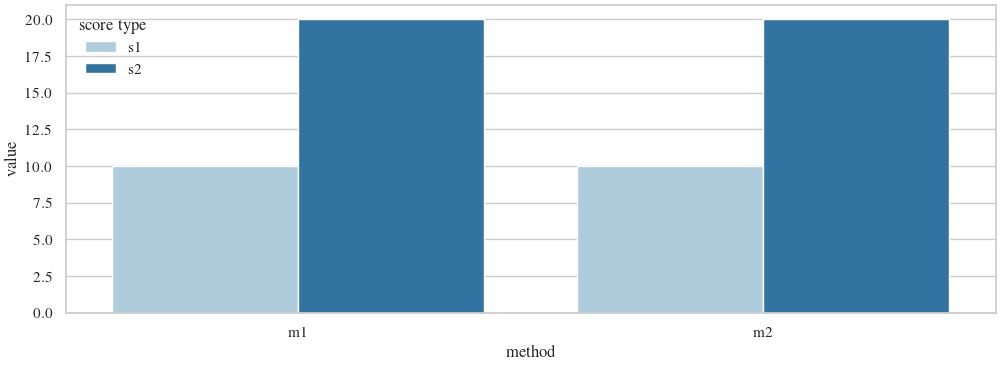

In [127]:
data = [
    ['m1','s1',10],
    ['m1','s2',20],
    ['m2','s1',10],
    ['m2','s2',20],
]
plt.figure(figsize=(12,4))
ax = plt.subplot(1, 1, 1)
df = pd.DataFrame(data=data, columns=['method','score type', 'value'])
sns.barplot(data = df, x = 'method', y = 'value', hue='score type',ax=ax)

In [49]:
# 读取测试数据
import pandas as pd
import os
save_path = {
    'lc':'output/test/lc/run01',
    'rr':'output/test/rr/run01',
    'rd':'output/test/rd/run01',
    'lg':'output/test/lg/run01',
    'ppo':'output/test/ppo/run01',
    'igd':'output/test/deepjs/ns_run01',
}
df_dic = {}
for key, save_path in save_path.items():
    df = pd.read_csv(os.path.join(save_path, 'all_data.csv'))
    df = df.drop(columns=['Unnamed: 0'])
    df_dic[key] = df
df_dic

{'lc':     balance_fitness  duration_fitness
 0         15.296061        532.114476
 1         16.756867        520.847421
 2         16.662470        526.982529
 3         15.484473        535.686855
 4         17.373928        539.853910
 5         16.119125        539.724126
 6         15.934849        537.826955
 7         17.074753        534.371215
 8         16.092400        540.174210
 9         18.315656        536.999501
 10        14.021537        532.441431
 11        16.153439        536.334942
 12        17.586032        534.858569
 13        15.928017        528.756073
 14        14.734716        531.959401
 15        16.273872        533.360233
 16        16.866880        527.610649
 17        15.371913        541.706822
 18        17.041107        531.127121
 19        16.079398        533.392180
 20        17.583565        531.872379
 21        16.794064        537.977704
 22        16.600080        538.044759
 23        14.610193        540.107820
 24        16.93227

In [53]:
import numpy as np
path = 'output/test/deepjs/ns_run01/data'

def get_all_rate(path, num=50):
    data = []
    for i in range(num):
        file_path = os.path.join(path, f'occupancy_rate_{i}.npy')
        data.append(np.load(file_path))
    return np.array(data)

data = get_all_rate(path)
data.shape

(50, 601, 10, 4)

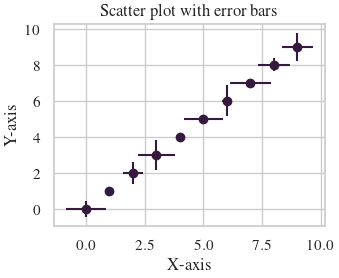

In [110]:
# 细节对比图
import matplotlib.pyplot as plt
import numpy as np

# 生成数据
x = np.arange(0, 10, 1)
y = x
x_err = np.random.rand(len(x))
y_err = np.random.rand(len(y))

# 绘制散点图
plt.errorbar(x, y, xerr=x_err, yerr=y_err, fmt='o')


# 添加标题和标签
plt.title('Scatter plot with error bars')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# 显示图形
plt.show()

# 章节2

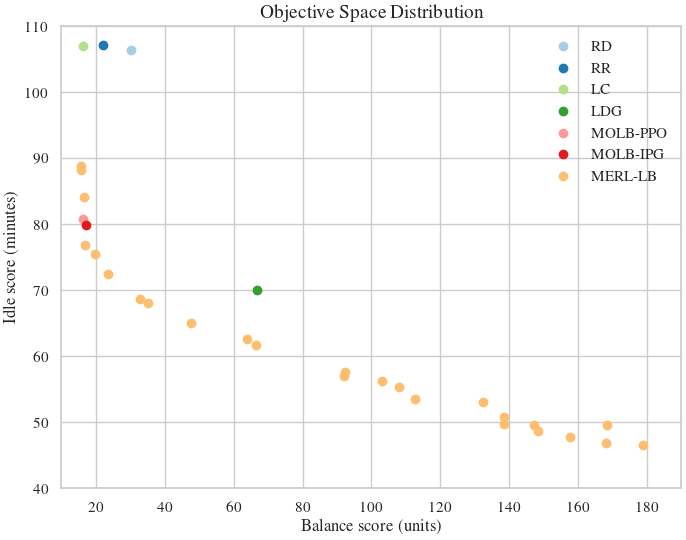

In [39]:
# 总览图
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scienceplots
plt.style.use('science')
sns.set()
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times"]})

save_path = {
    'RD':'output/test/rd/run01',
    'RR':'output/test/rr/run01',
    'LC':'output/test/lc/run01',
    'LDG':'output/test/lg/run01',
    'MOLB-PPO':'output/test/ppo/run02',
    'MOLB-IPG':'output/test/deepjs/ns_run01',
}

color = {
    'RR':'#0070c0',
    'RD':'#00b0f0',
    'LC':'output/test/lc/run01',
    'LDG':'output/test/lg/run01',
    'MOLB-PPO':'output/test/ppo/run02',
    'MOLB-IPG':'output/test/deepjs/ns_run01',
}
df_dic = {}
for key, save_path in save_path.items():
    df = pd.read_csv(os.path.join(save_path, 'mean_std.csv'))
    df = df.drop(columns=['Unnamed: 0'])
    df_dic[key] = df
df_dic

# sns.color_palette("Paired")
sns.set_palette("Paired")
data = []
plt.figure(figsize=(8,6))
for key, df in df_dic.items():
    data.append((key, df['balance_fitness_mean'][0], df['duration_fitness_mean'][0]/5, df['balance_fitness_std'][0], df['duration_fitness_std'][0]/5))
    plt.scatter(df['balance_fitness_mean'][0], df['duration_fitness_mean'][0]/5, label=key)
df = pd.DataFrame(data, columns=['methods', 'balance_score', 'idle_score','balance_std', 'idle_std'])

# plt.scatter(17.0905, 351.4006/5, label="WSGA")


# nsga
# nsga_df = pd.read_csv('output/test/nei_nsga/nsga_nei_run01_g30000_0/mean_std.csv')
# nsga_df = pd.read_csv('output/test/nsga/nsga_run05_g20000/nsga_mean_std.csv')
# nsga_df = nsga_df.drop(columns=['Unnamed: 0'])
# plt.scatter(nsga_df['balance_fitness_mean'], nsga_df['duration_fitness_mean']/5, label='MERL-LB1')

# nsga_df = pd.read_csv('output/test/nsga/nsga_run05_g30000/nsga_mean_std.csv')
# nsga_df = nsga_df.drop(columns=['Unnamed: 0'])
# plt.scatter(nsga_df['balance_fitness_mean'], nsga_df['duration_fitness_mean']/5, label='MERL-LB2')

# nsga_df = pd.read_csv('output/test/nsga/nsga_run05_g70000/nsga_mean_std.csv')
# nsga_df = nsga_df.drop(columns=['Unnamed: 0'])
# plt.scatter(nsga_df['balance_fitness_mean'], nsga_df['duration_fitness_mean']/5, label='MERL-LB3')

nsga_df = pd.read_csv('output/test/nei_nsga/nsga_nei_run01_g30000_0/mean_std.csv')
nsga_df = nsga_df.drop(columns=['Unnamed: 0'])
plt.scatter(nsga_df['balance_fitness_mean'], nsga_df['duration_fitness_mean']/5, label='MERL-LB')


# plt.scatter(16.8932, 353.3564/5, label="MERL-LB-WS")

# nsga_df = pd.read_csv('output/test/nei_nsga/nsga_nei_run01_g37000_0/mean_std.csv')
# nsga_df = nsga_df.drop(columns=['Unnamed: 0'])
# plt.scatter(nsga_df['balance_fitness_mean'], nsga_df['duration_fitness_mean']/5, label='NE-MERL-LB1')


plt.legend()
# y_major_locator=MultipleLocator(10)
# ax=plt.gca()
# ax.yaxis.set_major_locator(y_major_locator)
plt.xlim(10,190)
plt.ylim(40,110)
plt.xlabel("Balance score (units)")
plt.ylabel("Idle score (minutes)")
plt.title("Objective Space Distribution",fontsize=14)
plt.savefig('MERL-LB目标空间分布1.pdf', dpi=300, bbox_inches = 'tight')

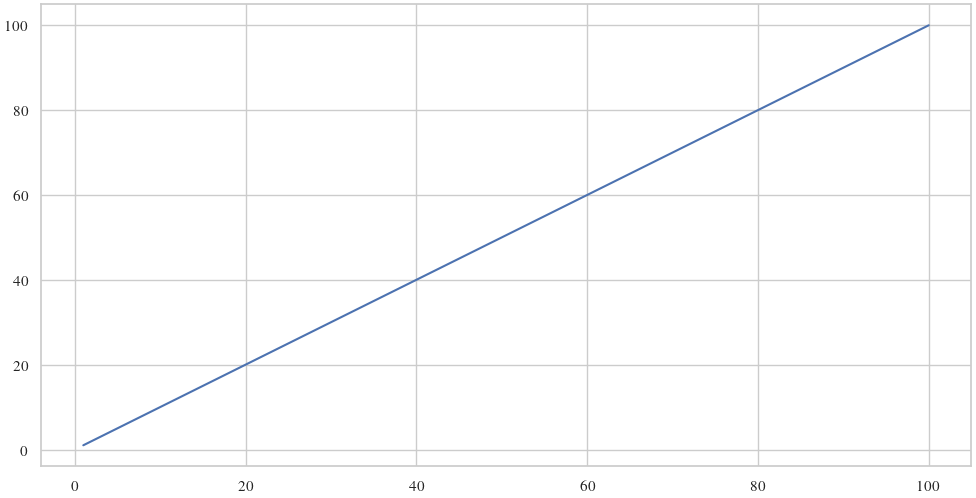

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()
sns.set_theme(style="whitegrid")
x = np.linspace(1,100,100)
y = x
plt.figure(figsize=(12,6))
plt.plot(x,y)




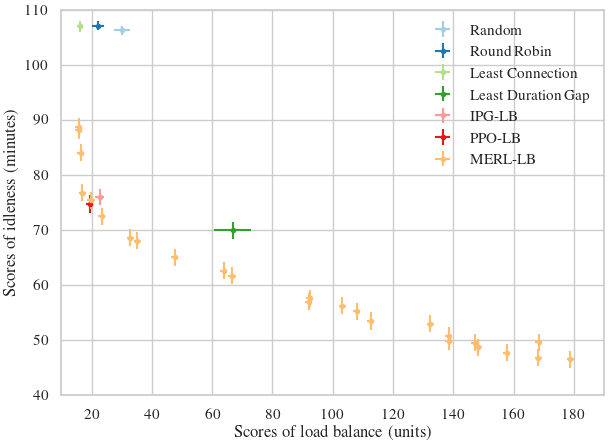

In [3]:
# 总览图
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scienceplots
plt.style.use('science')
sns.set()
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times"]})

save_path = {
    'Random':'output/test/rd/run01',
    'Round Robin':'output/test/rr/run01',
    'Least Connection':'output/test/lc/run01',
    'Least Duration Gap':'output/test/lg/run01',
    'IPG-LB':'output/test/igd/best_run01',
    'PPO-LB':'output/test/ppo/best_run01',
}
# save_path = {
#     'RD':'output/test/rd/run01',
#     'RR':'output/test/rr/run01',
#     'LC':'output/test/lc/run01',
#     'LDG':'output/test/lg/run01',
#     'MOLB-PPO':'output/test/ppo/run02',
#     'MOLB-IPG':'output/test/deepjs/ns_run01',
# }

df_dic = {}
for key, save_path in save_path.items():
    df = pd.read_csv(os.path.join(save_path, 'mean_std.csv'))
    df = df.drop(columns=['Unnamed: 0'])
    df_dic[key] = df
df_dic

# sns.color_palette("Paired")
sns.set_palette("Paired")
data = []
plt.figure(figsize=(7,5))
for key, df in df_dic.items():
    data.append((key, df['balance_fitness_mean'][0], df['duration_fitness_mean'][0]/5, df['balance_fitness_std'][0], df['duration_fitness_std'][0]/5))
    plt.errorbar(df['balance_fitness_mean'][0], df['duration_fitness_mean'][0]/5, xerr=df['balance_fitness_std'][0], yerr=df['duration_fitness_std'][0]/5, label=key, fmt='.')
df = pd.DataFrame(data, columns=['methods', 'balance_score', 'idle_score','balance_std', 'idle_std'])

# plt.scatter(17.0905, 351.4006/5, label="WSGA")


# nsga
# nsga_df = pd.read_csv('output/test/nei_nsga/nsga_nei_run01_g30000_0/mean_std.csv')
# nsga_df = pd.read_csv('output/test/nsga/nsga_run05_g20000/nsga_mean_std.csv')
# nsga_df = nsga_df.drop(columns=['Unnamed: 0'])
# plt.scatter(nsga_df['balance_fitness_mean'], nsga_df['duration_fitness_mean']/5, label='MERL-LB1')

# nsga_df = pd.read_csv('output/test/nsga/nsga_run05_g30000/nsga_mean_std.csv')
# nsga_df = nsga_df.drop(columns=['Unnamed: 0'])
# plt.scatter(nsga_df['balance_fitness_mean'], nsga_df['duration_fitness_mean']/5, label='MERL-LB2')

# nsga_df = pd.read_csv('output/test/nsga/nsga_run05_g70000/nsga_mean_std.csv')
# nsga_df = nsga_df.drop(columns=['Unnamed: 0'])
# plt.scatter(nsga_df['balance_fitness_mean'], nsga_df['duration_fitness_mean']/5, label='MERL-LB3')

nsga_df = pd.read_csv('output/test/nei_nsga/nsga_nei_run01_g30000_0/mean_std.csv')
nsga_df = nsga_df.drop(columns=['Unnamed: 0'])
plt.errorbar(nsga_df['balance_fitness_mean'], nsga_df['duration_fitness_mean']/5,xerr=nsga_df['balance_fitness_std'][0], yerr=nsga_df['duration_fitness_std'][0]/5,  label='MERL-LB', fmt='.')

# nsga_df = pd.read_csv('output/test/nei_nsga/nsga_nei_run01_g40000_0/mean_std.csv')
# nsga_df = nsga_df.drop(columns=['Unnamed: 0'])
# plt.errorbar(nsga_df['balance_fitness_mean'], nsga_df['duration_fitness_mean']/5,xerr=nsga_df['balance_fitness_std'][0], yerr=nsga_df['duration_fitness_std'][0]/5,  label='MERL-LB', fmt='.')


# plt.scatter(16.8932, 353.3564/5, label="MERL-LB-WS")

# nsga_df = pd.read_csv('output/test/nei_nsga/nsga_nei_run01_g37000_0/mean_std.csv')
# nsga_df = nsga_df.drop(columns=['Unnamed: 0'])
# plt.scatter(nsga_df['balance_fitness_mean'], nsga_df['duration_fitness_mean']/5, label='NE-MERL-LB1')

# plt.scatter(17.0905, 351.4006/5, label="WSGA", marker='.')
# plt.scatter(22.9, 352.4006/5, label="WSGA2", marker='.')

plt.legend()
# y_major_locator=MultipleLocator(10)
# ax=plt.gca()
# ax.yaxis.set_major_locator(y_major_locator)
plt.xlim(10,190)
plt.ylim(40,110)
plt.xlabel("Scores of load balance (units)")
plt.ylabel("Scores of idleness (minutes)")
# plt.title("The distribution of optimal policies on the objective space",fontsize=14)
plt.savefig('3-目标空间分布.pdf', dpi=300, bbox_inches = 'tight')

In [65]:
# 总览图
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scienceplots
plt.style.use('science')
sns.set()
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times"]})

save_path = {
    'RD':'output/test/rd/run01',
    'RR':'output/test/rr/run01',
    'LC':'output/test/lc/run01',
    'LDG':'output/test/lg/run01',
    'MOLB-PPO':'output/test/ppo/run02',
    'MOLB-IPG':'output/test/deepjs/ns_run01',
}

color = {
    'RR':'#0070c0',
    'RD':'#00b0f0',
    'LC':'output/test/lc/run01',
    'LDG':'output/test/lg/run01',
    'MOLB-PPO':'output/test/ppo/run02',
    'MOLB-IPG':'output/test/deepjs/ns_run01',
}
df_dic = {}
for key, save_path in save_path.items():
    df = pd.read_csv(os.path.join(save_path, 'mean_std.csv'))
    df = df.drop(columns=['Unnamed: 0'])
    df_dic[key] = df
df_dic

# sns.color_palette("Paired")
sns.set_palette("Paired")
data = []
plt.figure(figsize=(8,6))
for key, df in df_dic.items():
    data.append((key, df['balance_fitness_mean'][0], df['duration_fitness_mean'][0]/5, df['balance_fitness_std'][0], df['duration_fitness_std'][0]/5))
df = pd.DataFrame(data, columns=['methods', 'balance_score', 'idle_score','balance_std', 'idle_std'])
df = df.drop(columns=[ "balance_std","idle_std"])
df

methods  balance_score  idle_score
0        RD      30.145293  106.264011
1        RR      22.147829  107.118184
2        LC      16.265779  106.984172
3       LDG      66.886818   69.902415
4  MOLB-PPO      16.225490   80.669059
5  MOLB-IPG      17.046095   79.753591

<Figure size 800x600 with 0 Axes>

In [76]:
nsga_df = pd.read_csv('output/test/nei_nsga/nsga_nei_run01_g30000_0/mean_std.csv')
nsga_df = nsga_df.drop(columns=['Unnamed: 0'])
methods = [f'MERL-LB-{i+1}' for i in range(25)]
nsga_df['methods'] = methods
nsga_df['balance_score'] = nsga_df['balance_fitness_mean']
nsga_df['idle_score'] = nsga_df['duration_fitness_mean']/5
nsga_df['methods'] = methods
nsga_df = nsga_df.drop(columns=['id', 'train_balance', 'train_duration', 'balance_fitness_mean','duration_fitness_mean','balance_fitness_std','duration_fitness_std'])
nsga_df

methods  balance_score  idle_score
0    MERL-LB-1      15.702608   88.681115
1    MERL-LB-2      15.783412   88.092848
2    MERL-LB-3      16.425552   84.030153
3    MERL-LB-4      16.884068   76.751826
4    MERL-LB-5      19.812516   75.356877
5    MERL-LB-6      23.417386   72.437266
6    MERL-LB-7      32.775007   68.591150
7    MERL-LB-8      35.100235   68.034302
8    MERL-LB-9      47.563595   65.022120
9   MERL-LB-10      63.776991   62.536071
10  MERL-LB-11      66.584867   61.627909
11  MERL-LB-12      92.448923   57.512711
12  MERL-LB-13      92.055539   56.908708
13  MERL-LB-14     103.152865   56.177547
14  MERL-LB-15     107.931085   55.216123
15  MERL-LB-16     112.548362   53.424116
16  MERL-LB-17     132.419064   52.929818
17  MERL-LB-18     138.451176   50.686118
18  MERL-LB-19     138.571114   49.723383
19  MERL-LB-20     148.253291   48.632974
20  MERL-LB-21     147.122114   49.437129
21  MERL-LB-22     157.732984   47.639558
22  MERL-LB-23     168.169395   46.778209
23  MERL-LB-24     178.772801   46.476288
24  MERL-LB-25     168.385385   49.558753

In [ ]:
import seaborn as sns

In [77]:
df2 = pd.concat([df, nsga_df])
df2['balance_score'] = -df2['balance_score']
df2['idle_score'] = -df2['idle_score']
df2['normal_balance_score'] = (df2['balance_score'] - df2['balance_score'].min())/(df2['balance_score'].max()-df2['balance_score'].min())
df2['normal_idle_score'] = (df2['idle_score'] - df2['idle_score'].min())/(df2['idle_score'].max()-df2['idle_score'].min())
df2['sum score'] = df2['normal_balance_score'] + df2['normal_idle_score']
df2

methods  balance_score  idle_score  normal_balance_score  \
0           RD     -30.145293 -106.264011              0.911433   
1           RR     -22.147829 -107.118184              0.960476   
2           LC     -16.265779 -106.984172              0.996546   
3          LDG     -66.886818  -69.902415              0.686122   
4     MOLB-PPO     -16.225490  -80.669059              0.996794   
5     MOLB-IPG     -17.046095  -79.753591              0.991761   
0    MERL-LB-1     -15.702608  -88.681115              1.000000   
1    MERL-LB-2     -15.783412  -88.092848              0.999504   
2    MERL-LB-3     -16.425552  -84.030153              0.995567   
3    MERL-LB-4     -16.884068  -76.751826              0.992755   
4    MERL-LB-5     -19.812516  -75.356877              0.974797   
5    MERL-LB-6     -23.417386  -72.437266              0.952690   
6    MERL-LB-7     -32.775007  -68.591150              0.895306   
7    MERL-LB-8     -35.100235  -68.034302              0.881047   
8    MERL-LB-9     -47.563595  -65.022120              0.804618   
9   MERL-LB-10     -63.776991  -62.536071              0.705192   
10  MERL-LB-11     -66.584867  -61.627909              0.687973   
11  MERL-LB-12     -92.448923  -57.512711              0.529366   
12  MERL-LB-13     -92.055539  -56.908708              0.531779   
13  MERL-LB-14    -103.152865  -56.177547              0.463726   
14  MERL-LB-15    -107.931085  -55.216123              0.434425   
15  MERL-LB-16    -112.548362  -53.424116              0.406110   
16  MERL-LB-17    -132.419064  -52.929818              0.284256   
17  MERL-LB-18    -138.451176  -50.686118              0.247265   
18  MERL-LB-19    -138.571114  -49.723383              0.246530   
19  MERL-LB-20    -148.253291  -48.632974              0.187156   
20  MERL-LB-21    -147.122114  -49.437129              0.194092   
21  MERL-LB-22    -157.732984  -47.639558              0.129023   
22  MERL-LB-23    -168.169395  -46.778209              0.065024   
23  MERL-LB-24    -178.772801  -46.476288              0.000000   
24  MERL-LB-25    -168.385385  -49.558753              0.063699   

    normal_idle_score  sum score  
0            0.014086   0.925518  
1            0.000000   0.960476  
2            0.002210   0.998756  
3            0.613697   1.299819  
4            0.436153   1.432946  
5            0.451249   1.443010  
0            0.304032   1.304032  
1            0.313733   1.313237  
2            0.380727   1.376294  
3            0.500749   1.493504  
4            0.523752   1.498549  
5            0.571897   1.524587  
6            0.635320   1.530627  
7            0.644503   1.525550  
8            0.694175   1.498793  
9            0.735170   1.440362  
10           0.750146   1.438119  
11           0.818007   1.347373  
12           0.827967   1.359746  
13           0.840024   1.303750  
14           0.855878   1.290303  
15           0.885429   1.291539  
16           0.893580   1.177836  
17           0.930579   1.177844  
18           0.946455   1.192985  
19           0.964436   1.151591  
20           0.951175   1.145267  
21           0.980817   1.109840  
22           0.995021   1.060045  
23           1.000000   1.000000  
24           0.949169   1.012868

In [81]:
df3 = df2.sort_values('sum score', ascending=False)
df3.to_csv("排序后.csv")

In [27]:
_nsga_df = nsga_df.sort_values('balance_fitness_mean')
_nsga_df.to_csv('nsga_df_sort.csv')

In [3]:
nsga_df = pd.read_csv('output/test/nei_nsga/nsga_nei_run01_g30000_0/mean_std.csv')
nsga_df.head()

Unnamed: 0  id  train_balance  train_duration  balance_fitness_mean  \
0           0   1       11.55494       443.81281             15.702608   
1           1  18       12.27472       420.20100             15.783412   
2           2   3       12.70454       396.60416             16.425552   
3           3  19       13.91610       373.49867             16.884068   
4           4   0       18.66083       359.57953             19.812516   

   duration_fitness_mean  balance_fitness_std  duration_fitness_std  
0             443.405574             1.173044              7.786258  
1             440.464240             1.088183              9.696971  
2             420.150765             1.104297              7.298846  
3             383.759131             1.058291              6.233458  
4             376.784386             1.208772              7.442503

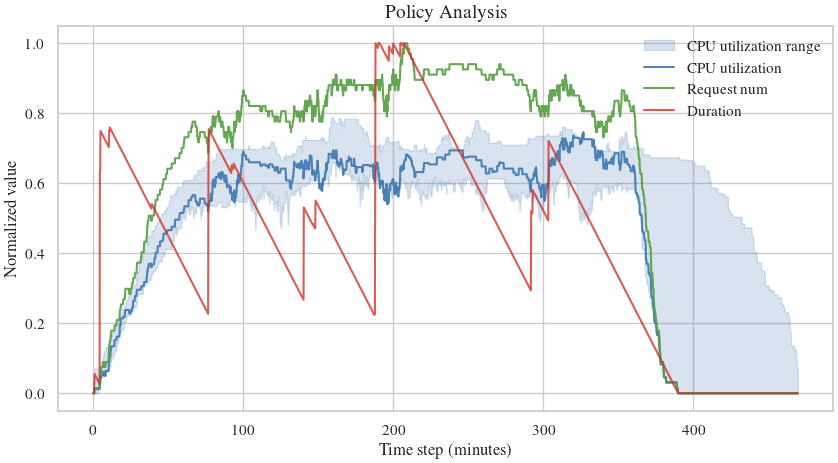

In [45]:
import numpy as np
# 探究动作关系
# 探究占用率与时长的关系
# ga_data_occupancy = np.load('output/test/GA/reward_mean/run01_m10/final_population/g_12242_f_-330.995_-0.033/24_f_-328.709_-0.029/m10_t10_n50_rt30/data/end_occupancy_rate_0.npy')
# ga_data_duration = np.load('output/test/GA/reward_mean/run01_m10/final_population/g_12242_f_-330.995_-0.033/24_f_-328.709_-0.029/m10_t10_n50_rt30/data/end_finish_time_0.npy')
# # ga_data_occupancy = np.load('output/test/GA/reward_mean/run01_m10/final_population/g_12242_f_-330.995_-0.033/24_f_-328.709_-0.029/test_m_10/data/end_occupancy_rate_0.npy')
# # ga_data_duration = np.load('output/test/GA/reward_mean/run01_m10/final_population/g_12242_f_-330.995_-0.033/24_f_-328.709_-0.029/test_m_10/data/end_finish_time_0.npy')
# ga_data_occupancy_m0 = ga_data_occupancy[:, :, 0]
# ga_data_duration_m0 = ga_data_duration[:, 0:1]
# ga_data_duration_m0 = (ga_data_duration_m0 - np.min(ga_data_duration_m0))/(np.max(ga_data_duration_m0) - np.min(ga_data_duration_m0))
# ga_fu_data = np.concatenate((ga_data_occupancy_m0, ga_data_duration_m0), axis=-1)
# plot_mutil_lines_chart(
#     ga_fu_data[:1500],
#     save_name='vis_ga_container_occupancy_rate_duration_all_m0.png',
#     xlabel="time",
#     ylabel="occupancy_rate",
#     title='Our_fus'
# )
# sns.set_theme()
# sns.set_palette("rocket")
root_path = 'output/test/wsga/t30_wsga_run05_g13440/b15.998_d349.591/data'
req_index = 0
ga_index = 0
r_index = 0
ga_data_occupancy = np.load(os.path.join(root_path, f'end_occupancy_rate_{req_index}.npy'))
ga_data_duration = np.load(os.path.join(root_path, f'end_finish_time_{req_index}.npy'))
ga_data_job_num = np.load(os.path.join(root_path, f'end_job_num_{req_index}.npy'))
# ga_data_occupancy = np.load('output/test/GA/reward_mean/run01_m10/final_population/g_12242_f_-330.995_-0.033/24_f_-328.709_-0.029/test_m_10/data/end_occupancy_rate_0.npy')
# ga_data_duration = np.load('output/test/GA/reward_mean/run01_m10/final_population/g_12242_f_-330.995_-0.033/24_f_-328.709_-0.029/test_m_10/data/end_finish_time_0.npy')
ga_data_occupancy_r0 = ga_data_occupancy[:, :, r_index]
ga_data_occupancy_r0_m0 = ga_data_occupancy_r0[:, ga_index]
ga_data_occupancy_r0_max = np.max(ga_data_occupancy_r0, axis=-1)
ga_data_occupancy_r0_min = np.min(ga_data_occupancy_r0, axis=-1)
ga_data_duration_m0 = ga_data_duration[:, ga_index]
ga_data_duration_m0 = (ga_data_duration_m0 - np.min(ga_data_duration_m0))/(np.max(ga_data_duration_m0) - np.min(ga_data_duration_m0))
ga_data_job_num_m0 = ga_data_job_num[:, ga_index]
ga_data_job_num_m0 = (ga_data_job_num_m0 - np.min(ga_data_job_num_m0))/(np.max(ga_data_job_num_m0) - np.min(ga_data_job_num_m0))
# ga_fu_data = np.concatenate((ga_data_occupancy_r0_m0, ga_data_occupancy_r0_max, ga_data_occupancy_r0_min, ga_data_duration_m0), axis=-1)
# plot_mutil_lines_chart(
#     ga_fu_data[:1500],
#     save_name='vis_ga_container_occupancy_rate_duration_all_m0.png',
#     xlabel="time",
#     ylabel="occupancy_rate",
#     title='Our_fus'
# )
max_time = 600 * 3 + 550
plt.figure(figsize=(10, 5))
# fig, ax1 = plt.subplots(figsize=(12, 6))
# ax1.figure(figsize=(12, 6))
# ax2 = ax1.twinx() 
x = range(max_time)
x = np.array(x)*12/60
# plt.plot(x, ga_data_occupancy_r0_max[:max_time], '--', label='max cpu occupancy')
# plt.plot(x, ga_data_occupancy_r0_min[:max_time], '--', label='min cpu occupancy')
plt.fill_between(x,ga_data_occupancy_r0_max[:max_time], ga_data_occupancy_r0_min[:max_time], color='#3c76af', alpha=0.2, label='CPU utilization range')
plt.plot(x, ga_data_occupancy_r0_m0[:max_time], '-', label='CPU utilization', c='#3c76af', alpha=0.9)
# ax1.legend(loc='lower right')
plt.plot(x, ga_data_job_num_m0[:max_time], '-', label='Request num', color='#549e3f', alpha=0.9)
plt.plot(x, ga_data_duration_m0[:max_time], '-', label='Duration', color='#d0352b', alpha=0.8)

plt.legend()
plt.xlabel('Time step (minutes)')
plt.ylabel('Normalized value')
plt.title('Policy Analysis', fontsize=14)
plt.savefig(f'output/image/策略动作研究_s{ga_index}_r{r_index}.png',  dpi=300, bbox_inches = 'tight')

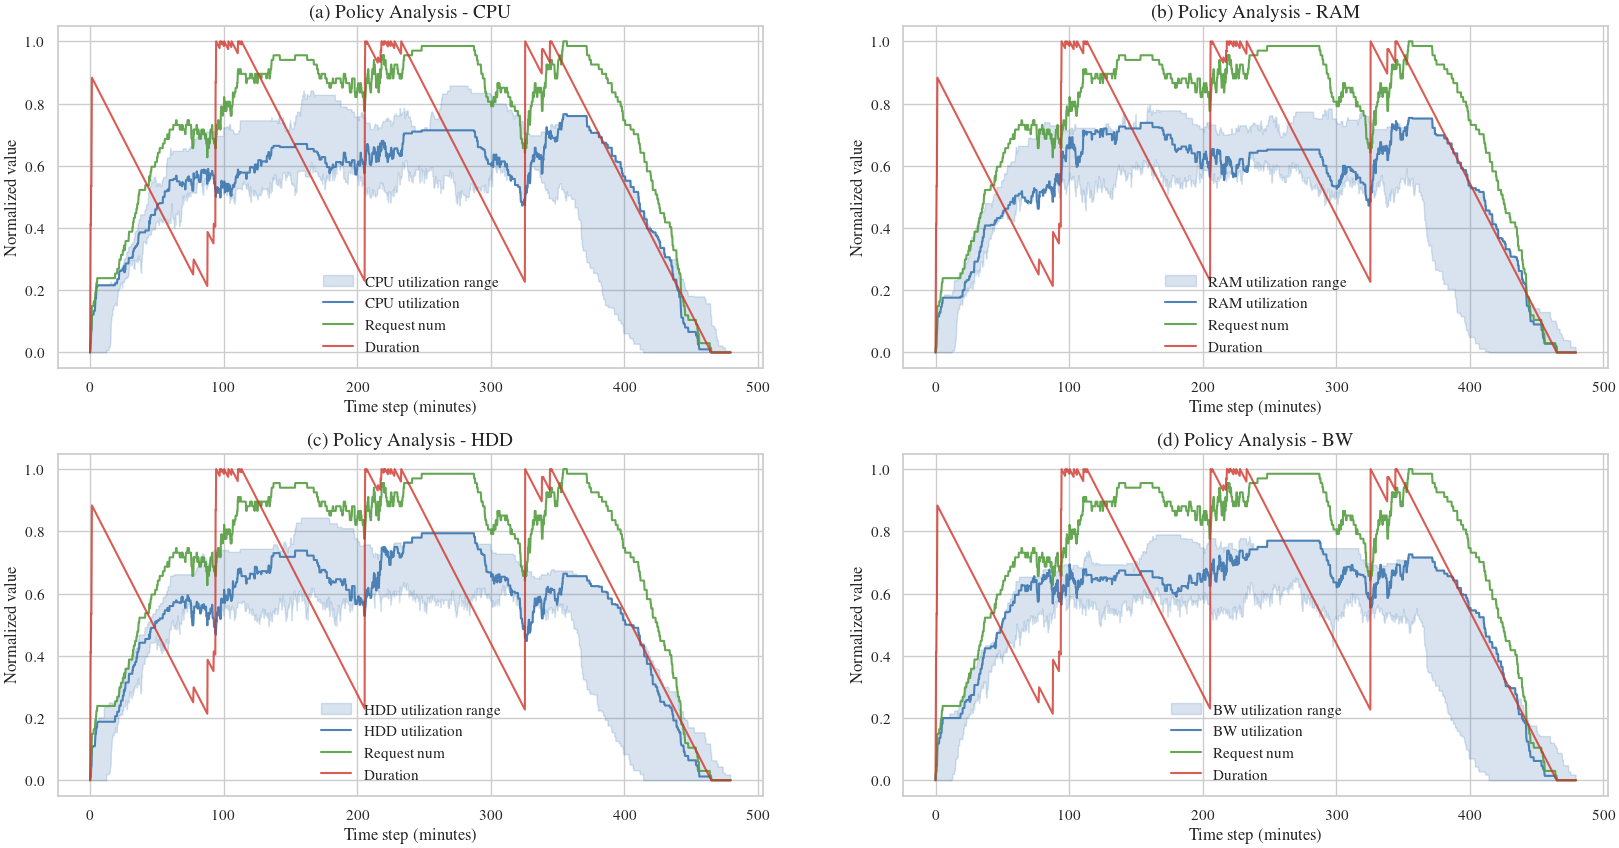

In [46]:
# 探究动作关系
# 探究占用率与时长的关系

plt.figure(figsize=(20, 10))
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times"]})

gindex = ['a', 'b', 'c', 'd']
score_list = ['CPU', 'RAM', 'HDD', 'BW']

# root_path = 'output/test/nei_nsga/t30_nsga_nei_run01_g30000_0/b18.661_d359.580/data'
root_path = 'output/test/nei_nsga/t30_nsga_nei_run01_g30000_0/b22.011_d342.446/data'
ga_index = 0
req_index = 0
max_time = 600 * 3 + 600-1
for r_index in range(4):

    ga_data_occupancy = np.load(os.path.join(root_path, f'end_occupancy_rate_{req_index}.npy'))
    ga_data_duration = np.load(os.path.join(root_path, f'end_finish_time_{req_index}.npy'))
    ga_data_job_num = np.load(os.path.join(root_path, f'end_job_num_{req_index}.npy'))

    ga_data_occupancy_r0 = ga_data_occupancy[:, :, r_index]
    ga_data_occupancy_r0_m0 = ga_data_occupancy_r0[:, ga_index]
    ga_data_occupancy_r0_max = np.max(ga_data_occupancy_r0, axis=-1)
    ga_data_occupancy_r0_min = np.min(ga_data_occupancy_r0, axis=-1)
    ga_data_duration_m0 = ga_data_duration[:, ga_index]
    ga_data_duration_m0 = (ga_data_duration_m0 - np.min(ga_data_duration_m0))/(np.max(ga_data_duration_m0) - np.min(ga_data_duration_m0))
    ga_data_job_num_m0 = ga_data_job_num[:, ga_index]
    ga_data_job_num_m0 = (ga_data_job_num_m0 - np.min(ga_data_job_num_m0))/(np.max(ga_data_job_num_m0) - np.min(ga_data_job_num_m0))

    x = range(max_time)
    x = np.array(x)*12/60

    ax = plt.subplot(2, 2, r_index + 1)
    plt.subplots_adjust(hspace=0.25, wspace=0.2)
    plt.fill_between(x,ga_data_occupancy_r0_max[:max_time], ga_data_occupancy_r0_min[:max_time], color='#3c76af', alpha=0.2, label=f'{score_list[r_index]} utilization range')
    plt.plot(x, ga_data_occupancy_r0_m0[:max_time], '-', label=f'{score_list[r_index]} utilization', c='#3c76af', alpha=0.9)

    plt.plot(x, ga_data_job_num_m0[:max_time], '-', label='Request num', color='#549e3f', alpha=0.9)
    plt.plot(x, ga_data_duration_m0[:max_time], '-', label='Duration', color='#d0352b', alpha=0.8)

    plt.legend()
    plt.xlabel('Time step (minutes)')
    plt.ylabel('Normalized value')
    plt.title(f'({gindex[r_index]}) Policy Analysis - {score_list[r_index]}', fontsize=14)
plt.savefig(f'output/image/nei_各资源策略动作研究_s{ga_index}_r{r_index}.pdf',  dpi=300, bbox_inches = 'tight')

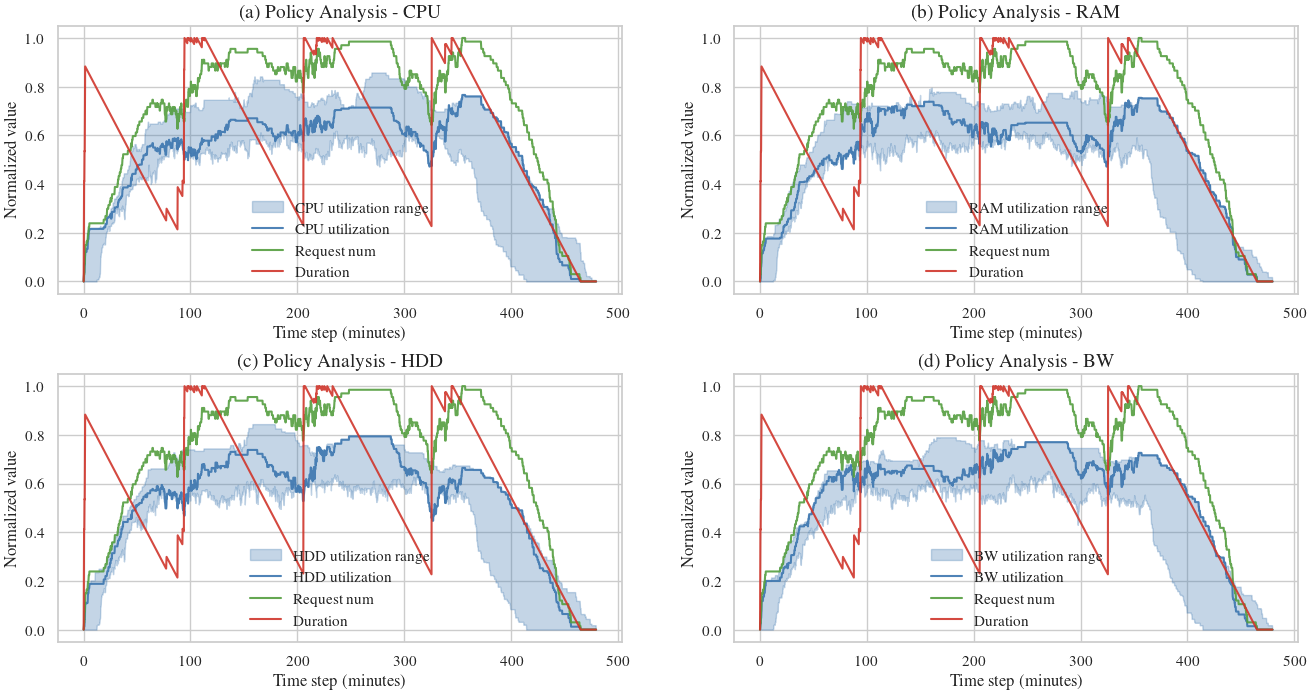

In [47]:
# 探究动作关系
# 探究占用率与时长的关系
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
import os
import scienceplots
plt.style.use('science')
sns.set()
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times"]})

plt.figure(figsize=(16, 8))
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times"]})

gindex = ['a', 'b', 'c', 'd']
score_list = ['CPU', 'RAM', 'HDD', 'BW']

# root_path = 'output/test/nei_nsga/t30_nsga_nei_run01_g30000_0/b18.661_d359.580/data'
root_path = 'output/test/nei_nsga/t30_nsga_nei_run01_g30000_0/b22.011_d342.446/data'
ga_index = 0
req_index = 0
max_time = 600 * 3 + 600-1
for r_index in range(4):

    ga_data_occupancy = np.load(os.path.join(root_path, f'end_occupancy_rate_{req_index}.npy'))
    ga_data_duration = np.load(os.path.join(root_path, f'end_finish_time_{req_index}.npy'))
    ga_data_job_num = np.load(os.path.join(root_path, f'end_job_num_{req_index}.npy'))

    ga_data_occupancy_r0 = ga_data_occupancy[:, :, r_index]
    ga_data_occupancy_r0_m0 = ga_data_occupancy_r0[:, ga_index]
    ga_data_occupancy_r0_max = np.max(ga_data_occupancy_r0, axis=-1)
    ga_data_occupancy_r0_min = np.min(ga_data_occupancy_r0, axis=-1)
    ga_data_duration_m0 = ga_data_duration[:, ga_index]
    ga_data_duration_m0 = (ga_data_duration_m0 - np.min(ga_data_duration_m0))/(np.max(ga_data_duration_m0) - np.min(ga_data_duration_m0))
    ga_data_job_num_m0 = ga_data_job_num[:, ga_index]
    ga_data_job_num_m0 = (ga_data_job_num_m0 - np.min(ga_data_job_num_m0))/(np.max(ga_data_job_num_m0) - np.min(ga_data_job_num_m0))

    x = range(max_time)
    x = np.array(x)*12/60

    ax = plt.subplot(2, 2, r_index + 1)
    plt.subplots_adjust(hspace=0.3, wspace=0.2)
    plt.fill_between(x,ga_data_occupancy_r0_max[:max_time], ga_data_occupancy_r0_min[:max_time], color='#3c76af', alpha=0.3, label=f'{score_list[r_index]} utilization range')
    plt.plot(x, ga_data_occupancy_r0_m0[:max_time], '-', label=f'{score_list[r_index]} utilization', c='#3c76af', alpha=0.9)

    plt.plot(x, ga_data_job_num_m0[:max_time], '-', label='Request num', color='#549e3f', alpha=0.9)
    plt.plot(x, ga_data_duration_m0[:max_time], '-', label='Duration', color='#d0352b', alpha=0.9)

    plt.legend()
    plt.xlabel('Time step (minutes)')
    plt.ylabel('Normalized value')
    plt.title(f'({gindex[r_index]}) Policy Analysis - {score_list[r_index]}', fontsize=14)
plt.savefig(f'output/image/nei_各资源策略动作研究_s{ga_index}_r{r_index}.pdf',  dpi=350, bbox_inches = 'tight')

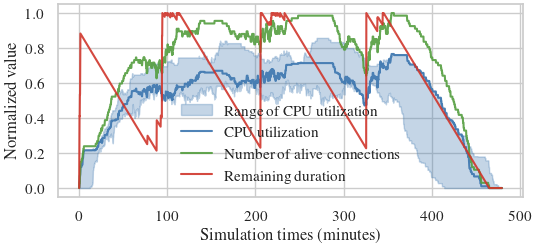

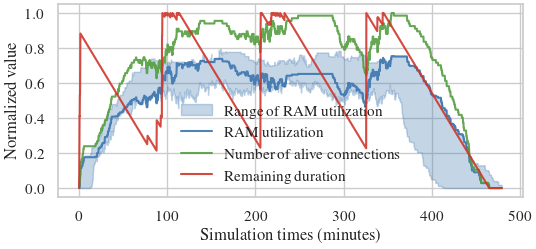

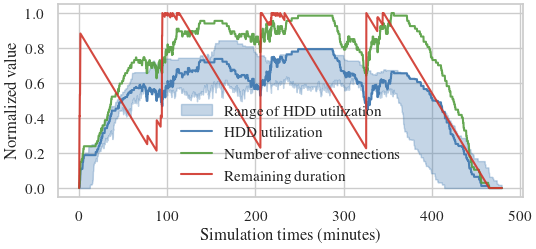

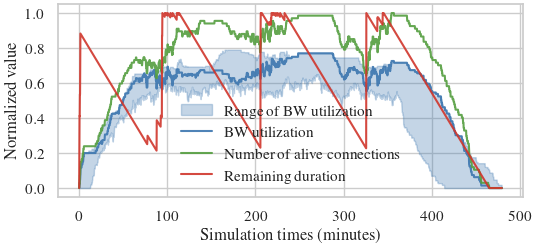

In [5]:
# 探究动作关系
# 探究占用率与时长的关系
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
import os
import scienceplots
plt.style.use('science')
sns.set()
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times"]})


plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times"]})

gindex = ['a', 'b', 'c', 'd']
score_list = ['CPU', 'RAM', 'HDD', 'BW']

# root_path = 'output/test/nei_nsga/t30_nsga_nei_run01_g30000_0/b18.661_d359.580/data'
root_path = 'output/test/nei_nsga/t30_nsga_nei_run01_g30000_0/b22.011_d342.446/data'
ga_index = 0
req_index = 0
max_time = 600 * 3 + 600-1
for r_index in range(4):
    plt.figure(figsize=(6, 2.5))
    ga_data_occupancy = np.load(os.path.join(root_path, f'end_occupancy_rate_{req_index}.npy'))
    ga_data_duration = np.load(os.path.join(root_path, f'end_finish_time_{req_index}.npy'))
    ga_data_job_num = np.load(os.path.join(root_path, f'end_job_num_{req_index}.npy'))

    ga_data_occupancy_r0 = ga_data_occupancy[:, :, r_index]
    ga_data_occupancy_r0_m0 = ga_data_occupancy_r0[:, ga_index]
    ga_data_occupancy_r0_max = np.max(ga_data_occupancy_r0, axis=-1)
    ga_data_occupancy_r0_min = np.min(ga_data_occupancy_r0, axis=-1)
    ga_data_duration_m0 = ga_data_duration[:, ga_index]
    ga_data_duration_m0 = (ga_data_duration_m0 - np.min(ga_data_duration_m0))/(np.max(ga_data_duration_m0) - np.min(ga_data_duration_m0))
    ga_data_job_num_m0 = ga_data_job_num[:, ga_index]
    ga_data_job_num_m0 = (ga_data_job_num_m0 - np.min(ga_data_job_num_m0))/(np.max(ga_data_job_num_m0) - np.min(ga_data_job_num_m0))

    x = range(max_time)
    x = np.array(x)*12/60

    # ax = plt.subplot(2, 2, r_index + 1)
    # plt.subplots_adjust(hspace=0.3, wspace=0.2)
    plt.fill_between(x,ga_data_occupancy_r0_max[:max_time], ga_data_occupancy_r0_min[:max_time], color='#3c76af', alpha=0.3, label=f'Range of {score_list[r_index]} utilization')
    plt.plot(x, ga_data_occupancy_r0_m0[:max_time], '-', label=f'{score_list[r_index]} utilization', c='#3c76af', alpha=0.9)

    plt.plot(x, ga_data_job_num_m0[:max_time], '-', label='Number of alive connections', color='#549e3f', alpha=0.9)
    plt.plot(x, ga_data_duration_m0[:max_time], '-', label='Remaining duration', color='#d0352b', alpha=0.9)

    plt.legend()
    plt.xlabel('Simulation times (minutes)')
    plt.ylabel('Normalized value')
    # plt.title(f'({gindex[r_index]}) Policy Analysis - {score_list[r_index]}', fontsize=14)
    plt.savefig(f'3-各资源策略动作研究-{r_index+1}.pdf',  dpi=350, bbox_inches = 'tight')

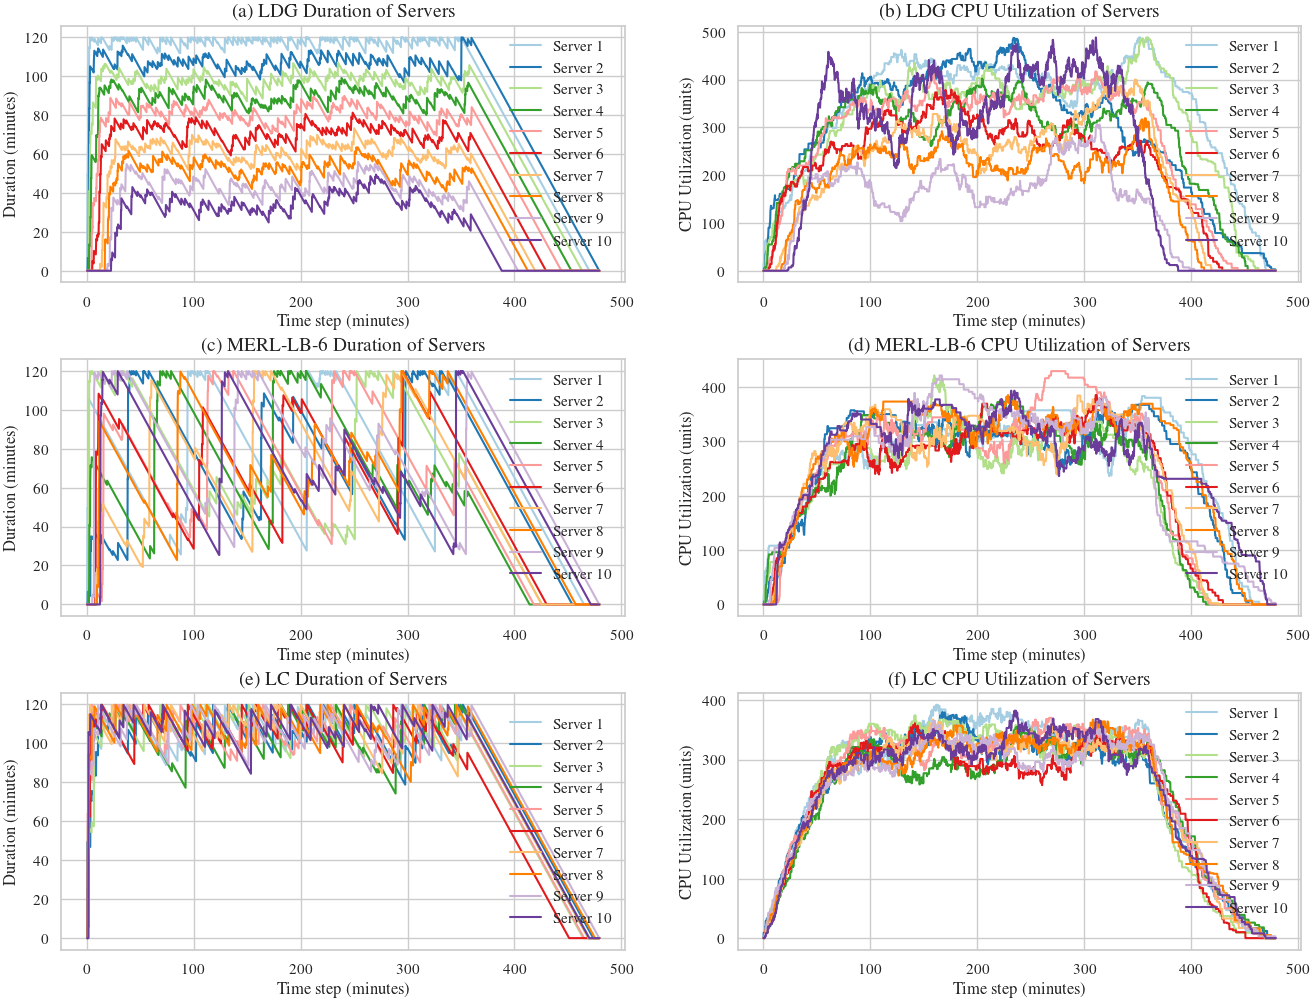

In [125]:
# 对比LDG和MERL
sns.set_palette("Paired")
root_path = 'output/test/lg/t30_run01/data'
ldg_data_duration = np.load(os.path.join(root_path, f'end_finish_time_{req_index}.npy'))
ldg_data_rate = np.load(os.path.join(root_path, f'end_occupancy_rate_{req_index}.npy'))[:,:,0]
root_path = 'output/test/lc/t30_run01/data'
lc_data_duration = np.load(os.path.join(root_path, f'end_finish_time_{req_index}.npy'))
lc_data_rate = np.load(os.path.join(root_path, f'end_occupancy_rate_{req_index}.npy'))[:,:,0]
ldg_data_duration.shape
plt.figure(figsize=(16,12))
x = range(len(ldg_data_duration))
x = np.array(x)*12/60
plt.subplot(3,2,1)
plt.subplots_adjust(hspace=0.3, wspace=0.2)
for i in range(10):
    plt.plot(x, ldg_data_duration[:,i]/5, label=f'Server {i+1}')
plt.legend()
plt.xlabel('Time step (minutes)')
plt.ylabel('Duration (minutes)')
plt.title(f'(a) LDG Duration of Servers', fontsize=14)

plt.subplot(3,2,3)
for i in range(10):
    plt.plot(x, ga_data_duration[:,i]/5, label=f'Server {i+1}')
plt.legend()
plt.xlabel('Time step (minutes)')
plt.ylabel('Duration (minutes)')
plt.title(f'(c) MERL-LB-6 Duration of Servers', fontsize=14)

plt.subplot(3,2,5)
for i in range(10):
    plt.plot(x, lc_data_duration[:,i]/5, label=f'Server {i+1}')
plt.legend(loc="right")
plt.xlabel('Time step (minutes)')
plt.ylabel('Duration (minutes)')
plt.title(f'(e) LC Duration of Servers', fontsize=14)

# plt.subplot(4,1,3)
# for i in range(10):
#     plt.plot(x, ldg_data_rate[:,i]*500, label=f'Sercer {i+1}')
# plt.legend()
# plt.xlabel('Time step (minutes)')
# plt.ylabel('Duration (minutes)')
# plt.title(f'(c) LGD CPU Utilization of Servers', fontsize=14)

# plt.subplot(4,1,4)
# for i in range(10):
#     plt.plot(x, ga_data_occupancy[:,i,0]*500, label=f'Sercer {i+1}')
# plt.legend()
# plt.xlabel('Time step (minutes)')
# plt.ylabel('Duration (minutes)')
# plt.title(f'(d) MERL-LB-6 CPU Utilization of Servers', fontsize=14)
# plt.savefig(f'output/image/LDG对比MERL-LB_s{ga_index}_r{r_index}1.pdf',  dpi=300, bbox_inches = 'tight')

plt.subplot(3,2,2)
for i in range(10):
    plt.plot(x, ldg_data_rate[:,i]*500, label=f'Server {i+1}')
plt.legend()
plt.xlabel('Time step (minutes)')
plt.ylabel('CPU Utilization (units)')
plt.title(f'(b) LDG CPU Utilization of Servers', fontsize=14)

plt.subplot(3,2,4)
for i in range(10):
    plt.plot(x, ga_data_occupancy[:,i,0]*500, label=f'Server {i+1}')
plt.legend()
plt.xlabel('Time step (minutes)')
plt.ylabel('CPU Utilization (units)')
plt.title(f'(d) MERL-LB-6 CPU Utilization of Servers', fontsize=14)

plt.subplot(3,2,6)
for i in range(10):
    plt.plot(x, lc_data_rate[:,i]*500, label=f'Server {i+1}')
plt.legend()
plt.xlabel('Time step (minutes)')
plt.ylabel('CPU Utilization (units)')
plt.title(f'(f) LC CPU Utilization of Servers', fontsize=14)
plt.savefig(f'output/image/LDG对比MERL-LB_s{ga_index}_r{r_index}2.pdf',  dpi=300, bbox_inches = 'tight')

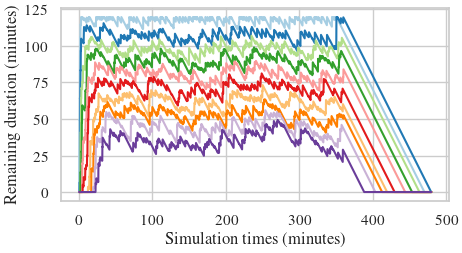

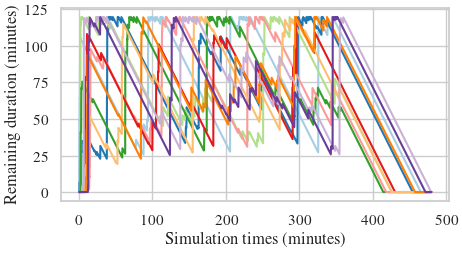

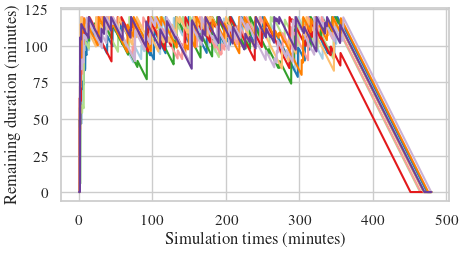

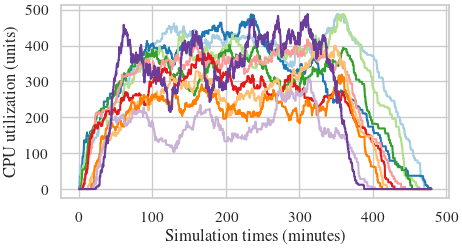

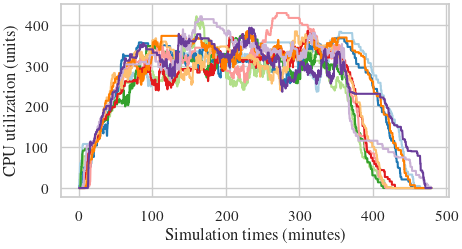

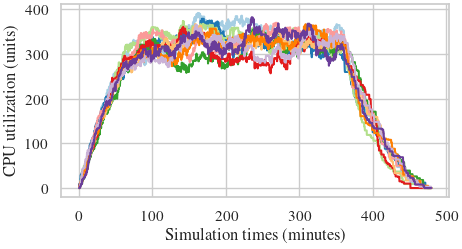

In [62]:
# 对比LDG和MERL
sns.set_palette("Paired")
root_path = 'output/test/lg/t30_run01/data'
ldg_data_duration = np.load(os.path.join(root_path, f'end_finish_time_{req_index}.npy'))
ldg_data_rate = np.load(os.path.join(root_path, f'end_occupancy_rate_{req_index}.npy'))[:,:,0]
root_path = 'output/test/lc/t30_run01/data'
lc_data_duration = np.load(os.path.join(root_path, f'end_finish_time_{req_index}.npy'))
lc_data_rate = np.load(os.path.join(root_path, f'end_occupancy_rate_{req_index}.npy'))[:,:,0]
ldg_data_duration.shape
plt.figure(figsize=(5,2.5))
x = range(len(ldg_data_duration))
x = np.array(x)*12/60
plt.subplot(1,1,1)
plt.subplots_adjust(hspace=0.3, wspace=0.2)
for i in range(10):
    plt.plot(x, ldg_data_duration[:,i]/5, label=f'Server {i+1}')
# plt.legend()
plt.xlabel('Simulation times (minutes)')
plt.ylabel('Remaining duration (minutes)')
# plt.title(f'(a) LDG Duration of Servers', fontsize=14)
plt.savefig(f'3-LDG_MERL-LB_LC-1.pdf',  dpi=300, bbox_inches = 'tight')

# plt.subplot(3,2,3)
plt.figure(figsize=(5,2.5))
for i in range(10):
    plt.plot(x, ga_data_duration[:,i]/5, label=f'Server {i+1}')
# plt.legend()
plt.xlabel('Simulation times (minutes)')
plt.ylabel('Remaining duration (minutes)')
# plt.title(f'(c) MERL-LB-6 Duration of Servers', fontsize=14)
plt.savefig(f'3-LDG_MERL-LB_LC-3.pdf',  dpi=300, bbox_inches = 'tight')

# plt.subplot(3,2,5)
plt.figure(figsize=(5,2.5))
for i in range(10):
    plt.plot(x, lc_data_duration[:,i]/5, label=f'Server {i+1}')
# plt.legend(loc="right")
plt.xlabel('Simulation times (minutes)')
plt.ylabel('Remaining duration (minutes)')
# plt.title(f'(e) LC Duration of Servers', fontsize=14)
plt.savefig(f'3-LDG_MERL-LB_LC-5.pdf',  dpi=300, bbox_inches = 'tight')

# plt.subplot(3,2,2)
plt.figure(figsize=(5,2.5))
for i in range(10):
    plt.plot(x, ldg_data_rate[:,i]*500, label=f'Server {i+1}')
# plt.legend()
plt.xlabel('Simulation times (minutes)')
plt.ylabel('CPU utilization (units)')
# plt.title(f'(b) LDG CPU Utilization of Servers', fontsize=14)
plt.savefig(f'3-LDG_MERL-LB_LC-2.pdf',  dpi=300, bbox_inches = 'tight')


# plt.subplot(3,2,4)
plt.figure(figsize=(5,2.5))
for i in range(10):
    plt.plot(x, ga_data_occupancy[:,i,0]*500, label=f'Server {i+1}')
# plt.legend()
plt.xlabel('Simulation times (minutes)')
plt.ylabel('CPU utilization (units)')
# plt.title(f'(d) MERL-LB-6 CPU Utilization of Servers', fontsize=14)
plt.savefig(f'3-LDG_MERL-LB_LC-4.pdf',  dpi=300, bbox_inches = 'tight')

# plt.subplot(3,2,6)
plt.figure(figsize=(5,2.5))
for i in range(10):
    plt.plot(x, lc_data_rate[:,i]*500, label=f'Server {i+1}')
# plt.legend()
plt.xlabel('Simulation times (minutes)')
plt.ylabel('CPU utilization (units)')
# plt.title(f'(f) LC CPU Utilization of Servers', fontsize=14)
# plt.savefig(f'output/image/LDG对比MERL-LB_s{ga_index}_r{r_index}2.pdf',  dpi=300, bbox_inches = 'tight')
plt.savefig(f'3-LDG_MERL-LB_LC-6.pdf',  dpi=300, bbox_inches = 'tight')

In [39]:
np.linspace(0, 7.5 * 60 // 3, 6, dtype=np.int32)

array([  0,  30,  60,  90, 120, 150], dtype=int32)

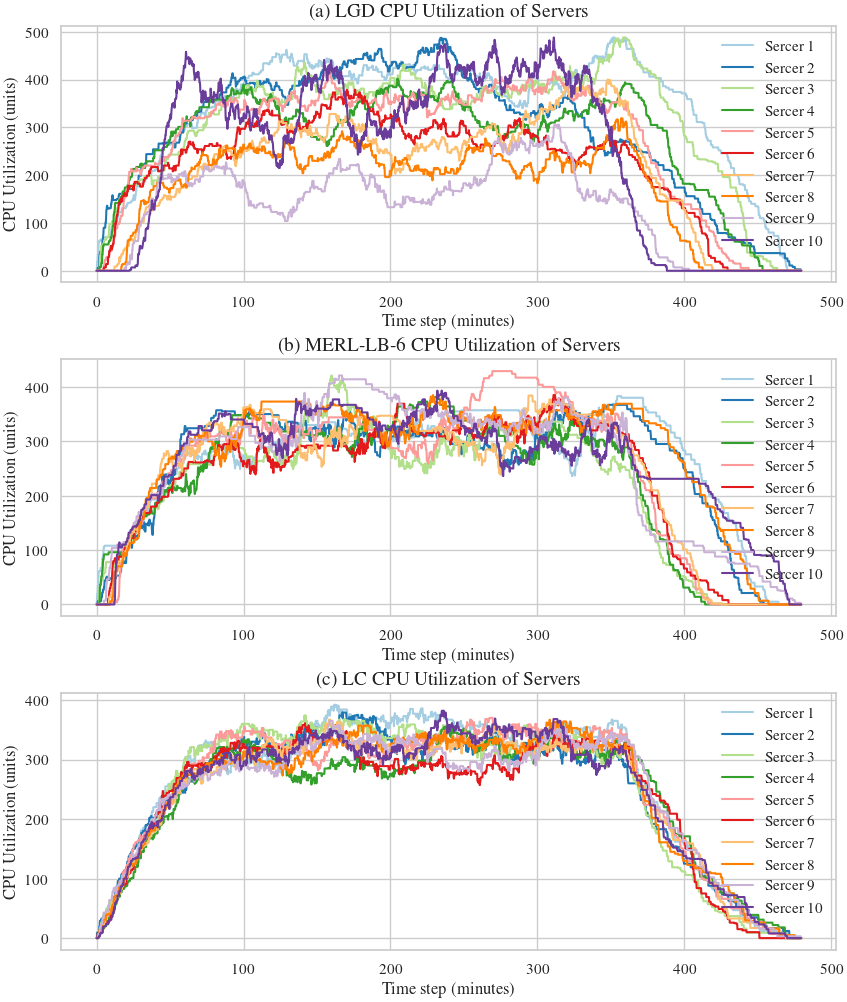

In [36]:
# 对比LDG和MERL
# sns.set_palette("Paired")
# root_path = 'output/test/lg/t30_run01/data'
# ldg_data_duration = np.load(os.path.join(root_path, f'end_finish_time_{req_index}.npy'))
# ldg_data_rate = np.load(os.path.join(root_path, f'end_occupancy_rate_{req_index}.npy'))[:,:,0]
# ldg_data_duration.shape
# plt.figure(figsize=(10,12))
x = range(len(ldg_data_duration))
x = np.array(x)*12/60
# plt.subplot(2,1,1)
plt.subplots_adjust(hspace=0.3, wspace=0.2)
# for i in range(10):
#     plt.plot(x, ldg_data_duration[:,i]/5, label=f'Sercer {i+1}')
# plt.legend()
# plt.xlabel('Time step (minutes)')
# plt.ylabel('Normalized value')
# plt.title(f'(a) LGD Duration of Servers', fontsize=14)

# plt.subplot(2,1,2)
# for i in range(10):
#     plt.plot(x, ga_data_duration[:,i]/5, label=f'Sercer {i+1}')
# plt.legend()
# plt.xlabel('Time step (minutes)')
# plt.ylabel('Duration (minutes)')
# plt.title(f'(b) MERL-LB-6 Duration of Servers', fontsize=14)

plt.subplot(3,1,1)
for i in range(10):
    plt.plot(x, ldg_data_rate[:,i]*500, label=f'Sercer {i+1}')
plt.legend()
plt.xlabel('Time step (minutes)')
plt.ylabel('CPU Utilization (units)')
plt.title(f'(a) LGD CPU Utilization of Servers', fontsize=14)

plt.subplot(3,1,2)
for i in range(10):
    plt.plot(x, ga_data_occupancy[:,i,0]*500, label=f'Sercer {i+1}')
plt.legend()
plt.xlabel('Time step (minutes)')
plt.ylabel('CPU Utilization (units)')
plt.title(f'(b) MERL-LB-6 CPU Utilization of Servers', fontsize=14)

plt.subplot(3,1,3)
for i in range(10):
    plt.plot(x, lc_data_rate[:,i]*500, label=f'Sercer {i+1}')
plt.legend()
plt.xlabel('Time step (minutes)')
plt.ylabel('CPU Utilization (units)')
plt.title(f'(c) LC CPU Utilization of Servers', fontsize=14)
plt.savefig(f'output/image/LDG对比MERL-LB_s{ga_index}_r{r_index}2.pdf',  dpi=300, bbox_inches = 'tight')

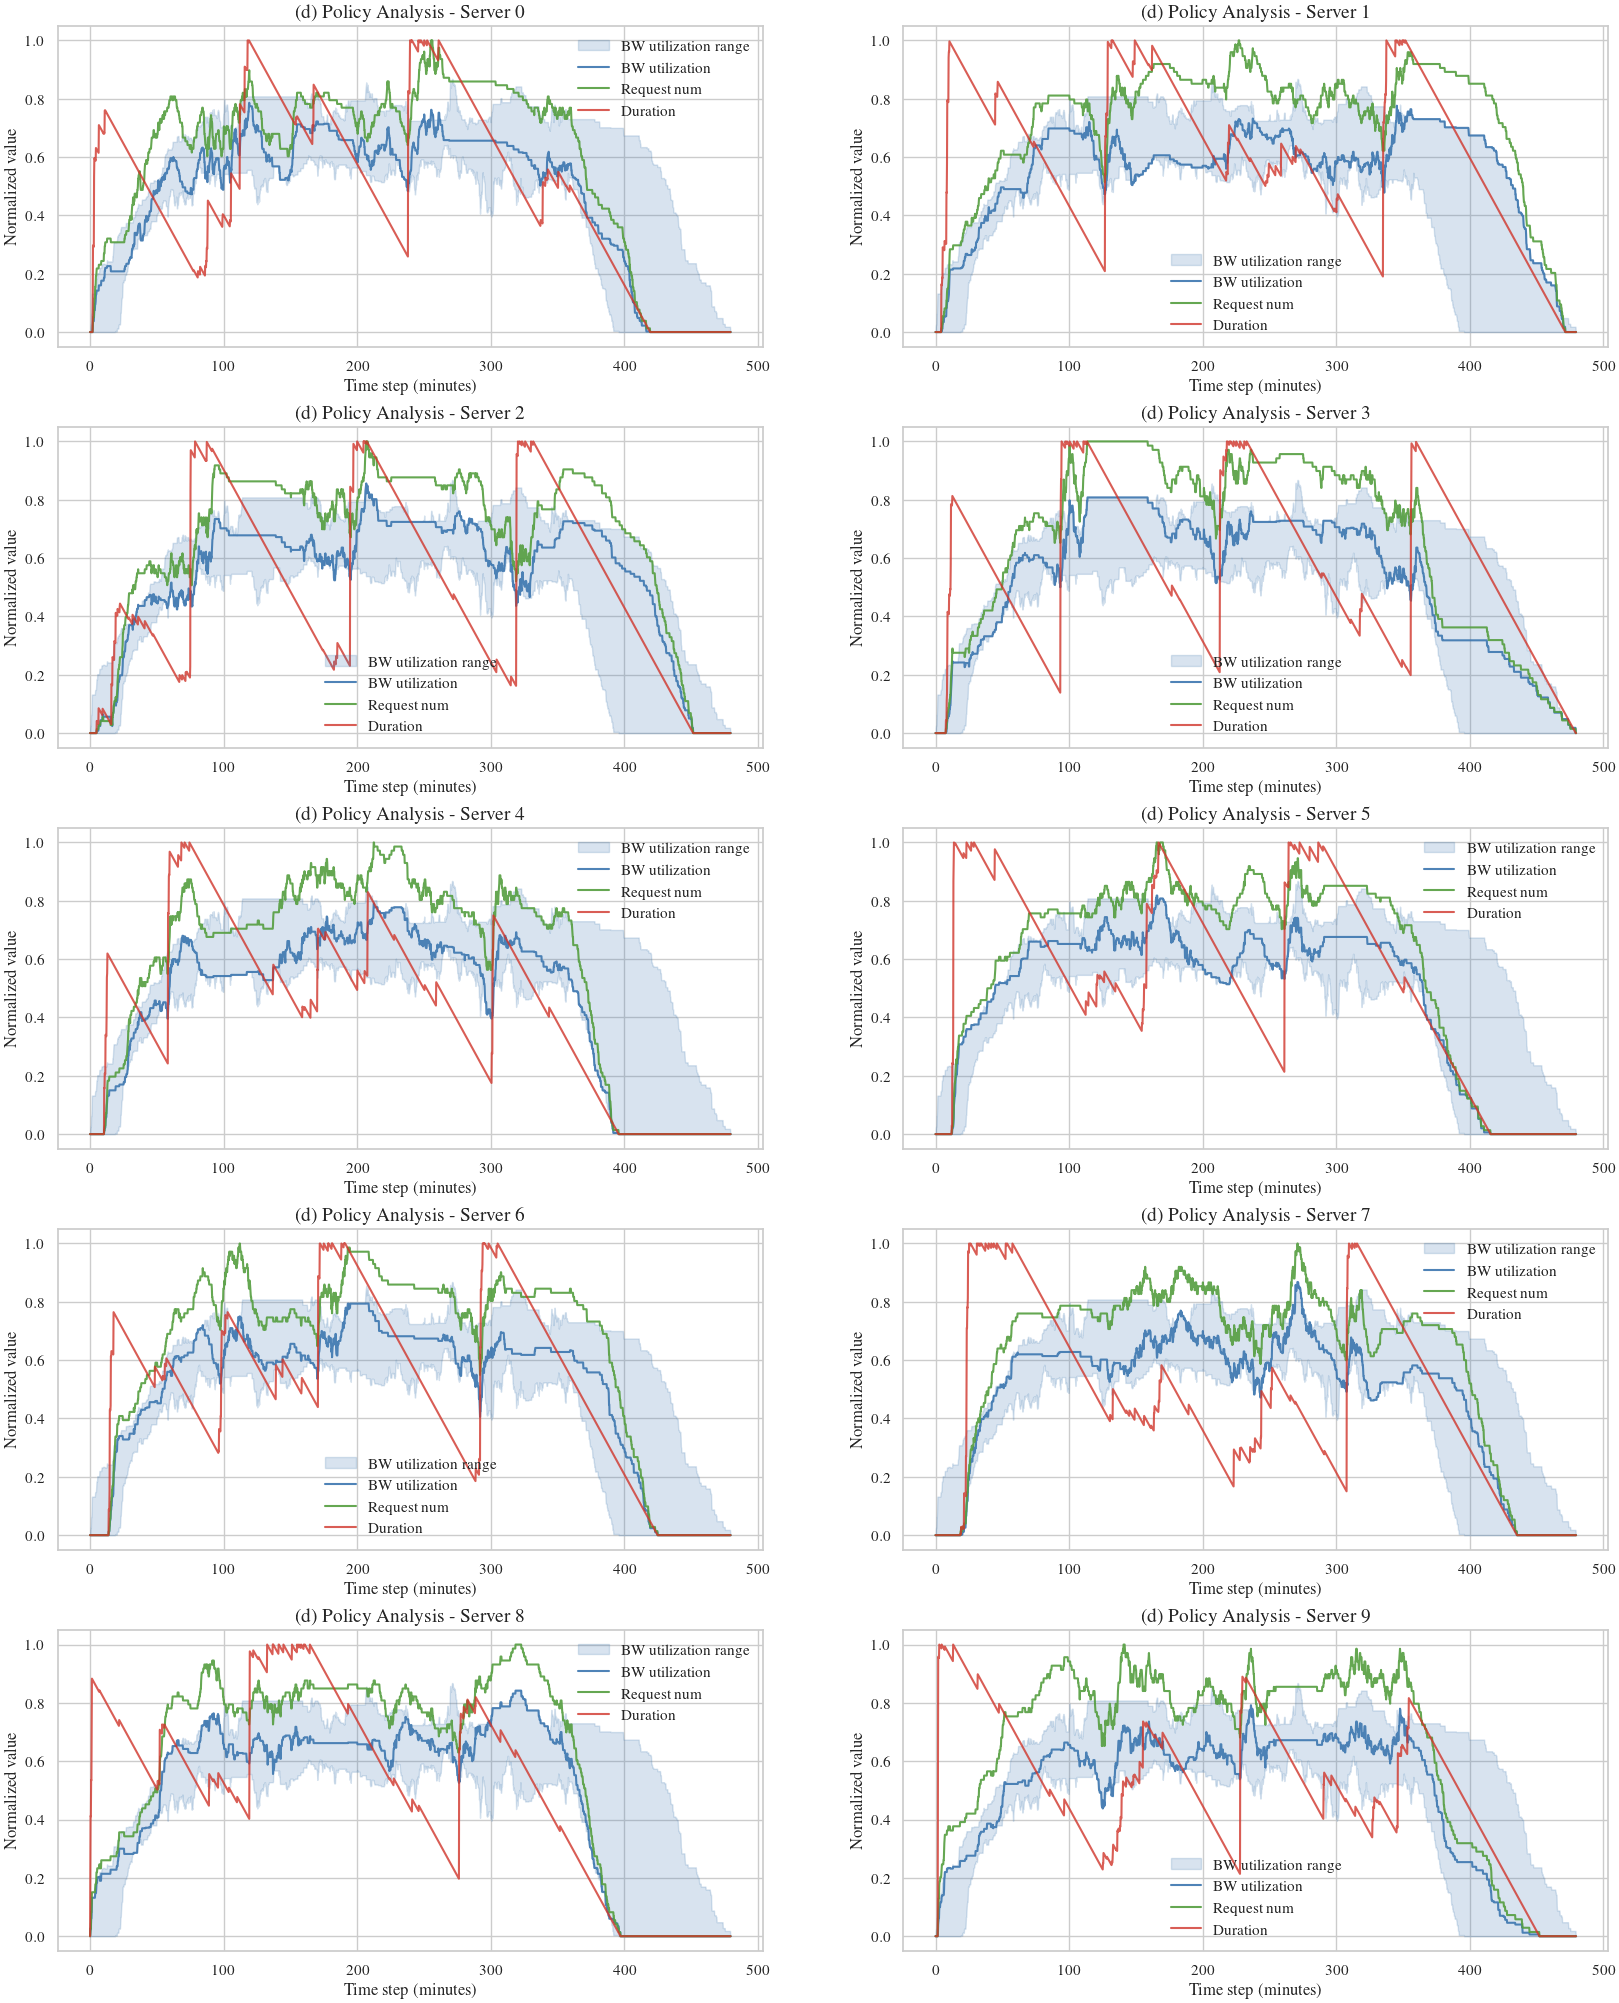

In [106]:
# 探究动作关系
# 探究占用率与时长的关系

plt.figure(figsize=(20, 5*5))
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times"]})

gindex = ['a', 'b', 'c', 'd']
score_list = ['CPU', 'RAM', 'HDD', 'BW']

root_path = 'output/test/nei_nsga/t30_nsga_nei_run01_g30000_0/b30.326_d330.753/data'
ga_index = 1
req_index = 0
max_time = 600 * 3 + 600-1
for idx, ga_index in enumerate(range(10)):

    ga_data_occupancy = np.load(os.path.join(root_path, f'end_occupancy_rate_{req_index}.npy'))
    ga_data_duration = np.load(os.path.join(root_path, f'end_finish_time_{req_index}.npy'))
    ga_data_job_num = np.load(os.path.join(root_path, f'end_job_num_{req_index}.npy'))

    ga_data_occupancy_r0 = ga_data_occupancy[:, :, r_index]
    ga_data_occupancy_r0_m0 = ga_data_occupancy_r0[:, ga_index]
    ga_data_occupancy_r0_max = np.max(ga_data_occupancy_r0, axis=-1)
    ga_data_occupancy_r0_min = np.min(ga_data_occupancy_r0, axis=-1)
    ga_data_duration_m0 = ga_data_duration[:, ga_index]
    ga_data_duration_m0 = (ga_data_duration_m0 - np.min(ga_data_duration_m0))/(np.max(ga_data_duration_m0) - np.min(ga_data_duration_m0))
    ga_data_job_num_m0 = ga_data_job_num[:, ga_index]
    ga_data_job_num_m0 = (ga_data_job_num_m0 - np.min(ga_data_job_num_m0))/(np.max(ga_data_job_num_m0) - np.min(ga_data_job_num_m0))

    x = range(max_time)
    x = np.array(x)*12/60

    ax = plt.subplot(5, 2, idx + 1)
    plt.subplots_adjust(hspace=0.25, wspace=0.2)
    plt.fill_between(x,ga_data_occupancy_r0_max[:max_time], ga_data_occupancy_r0_min[:max_time], color='#3c76af', alpha=0.2, label=f'{score_list[r_index]} utilization range')
    plt.plot(x, ga_data_occupancy_r0_m0[:max_time], '-', label=f'{score_list[r_index]} utilization', c='#3c76af', alpha=0.9)

    plt.plot(x, ga_data_job_num_m0[:max_time], '-', label='Request num', color='#549e3f', alpha=0.9)
    plt.plot(x, ga_data_duration_m0[:max_time], '-', label='Duration', color='#d0352b', alpha=0.8)

    plt.legend()
    plt.xlabel('Time step (minutes)')
    plt.ylabel('Normalized value')
    plt.title(f'({gindex[r_index]}) Policy Analysis - Server {ga_index}', fontsize=14)
plt.savefig(f'output/image/nei_各服务器策略动作研究_r{r_index}.png',  dpi=300, bbox_inches = 'tight')

In [ ]:
list = {
    1:'output/train/nei_nsga/g30000_0/0_-443.81281_-11.55494.pth',
    6:'output/train/nei_nsga/g30000_0/5_-342.44642_-22.01056.pth',
    11:'output/train/nei_nsga/g30000_0/19_-296.48419_-63.50586.pth',
    25:'output/train/nei_nsga/g30000_0/12_-218.78153_-174.13751.pth'
}

In [33]:
# 负载影响
save_path = {
    'Random':'output/test/rd/user_load_run01',
    'Round Robin':'output/test/rr/user_load_run01',
    'Least Connection':'output/test/lc/user_load_run01',
    'Least Duration Gap':'output/test/lg/user_load_run01',
    'IPG-LB':'output/test/igd/user_load_run01',
    'PPO-LB':'output/test/ppo/user_load_run01',
    'MERL-LB-1':'output/test/nei_nsga/user_load_test01-1',
    'MERL-LB-6':'output/test/nei_nsga/user_load_test01-6',
    'MOLB-LB-11':'output/test/nei_nsga/user_load_test01-11',
    'MOLB-LB-25':'output/test/nei_nsga/user_load_test01-25',
}
load_list = [0.300,0.450,0.600,0.750,0.900,1.050]

def get_all_rate(path, num=50):
    data = []
    for i in range(num):
        file_path = os.path.join(path, f'occupancy_rate_{i}.npy')
        data.append(np.load(file_path))
    return np.array(data)

data = []
for key, item_path in save_path.items():
    for load in load_list:
        final_path = f'{item_path}/user_load_rate_{load:.3f}/data'
        item_data = get_all_rate(final_path)

        _score = []
        for item in item_data:
            item_score = np.array(item) * 500
            item_score = np.mean(np.std(item_score, axis=-2))
            _score.append(item_score)
        _method = [key] * len(_score)
        _load = [int(load*100)] * len(_score)
        _item_data = zip(_method, _load,  _score)
        _item_df = pd.DataFrame(_item_data, columns=['Method', 'Average load', 'Score'])
        data.append(_item_df)

df4 = pd.concat(data, axis=0)

/tmp/ipykernel_592/4001470854.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)
/tmp/ipykernel_592/4001470854.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)
/tmp/ipykernel_592/4001470854.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)
/tmp/ipykernel_592/

In [35]:
import numpy as np
# 负载影响
save_path = {
    'Random':'output/test/rd/user_load_run01',
    'Round Robin':'output/test/rr/user_load_run01',
    'Least Connection':'output/test/lc/user_load_run01',
    'Least Duration Gap':'output/test/lg/user_load_run01',
    'IPG-LB':'output/test/igd/user_load_run01',
    'PPO-LB':'output/test/ppo/user_load_run01',
    'MERL-LB-1':'output/test/nei_nsga/user_load_test01-1',
    'MERL-LB-6':'output/test/nei_nsga/user_load_test01-6',
    'MOLB-LB-11':'output/test/nei_nsga/user_load_test01-11',
    'MOLB-LB-25':'output/test/nei_nsga/user_load_test01-25',
}
load_list = [0.300,0.450,0.600,0.750,0.900,1.050]
score_list = ['CPU', 'RAM', 'HDD', 'BW']

def get_finish(path, num=50):
    data = []
    for i in range(num):
        file_path = os.path.join(path, f'finish_time_{i}.npy')
        data.append(np.load(file_path))
    return np.array(data)

data = []
for key, item_path in save_path.items():
    for load in load_list:
        final_path = f'{item_path}/user_load_rate_{load:.3f}/data'
        item_data = get_finish(final_path)
        _score = []
        for item in item_data:
            item_score = np.array(item)
            item_score = np.mean(item_score)
            _score.append(item_score/5)
        _method = [key] * len(_score)
        _load = [int(load*100)] * len(_score)
        _score_type = ['Idle'] * len(_score)
        _item_data = zip(_method, _load, _score_type,  _score)
        _item_df = pd.DataFrame(_item_data, columns=['Method', 'Average load',  'Score type', 'Score'])
        data.append(_item_df)

df5 = pd.concat(data, axis=0)

/tmp/ipykernel_592/3374884620.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)
/tmp/ipykernel_592/3374884620.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)
/tmp/ipykernel_592/3374884620.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)
/tmp/ipykernel_592/

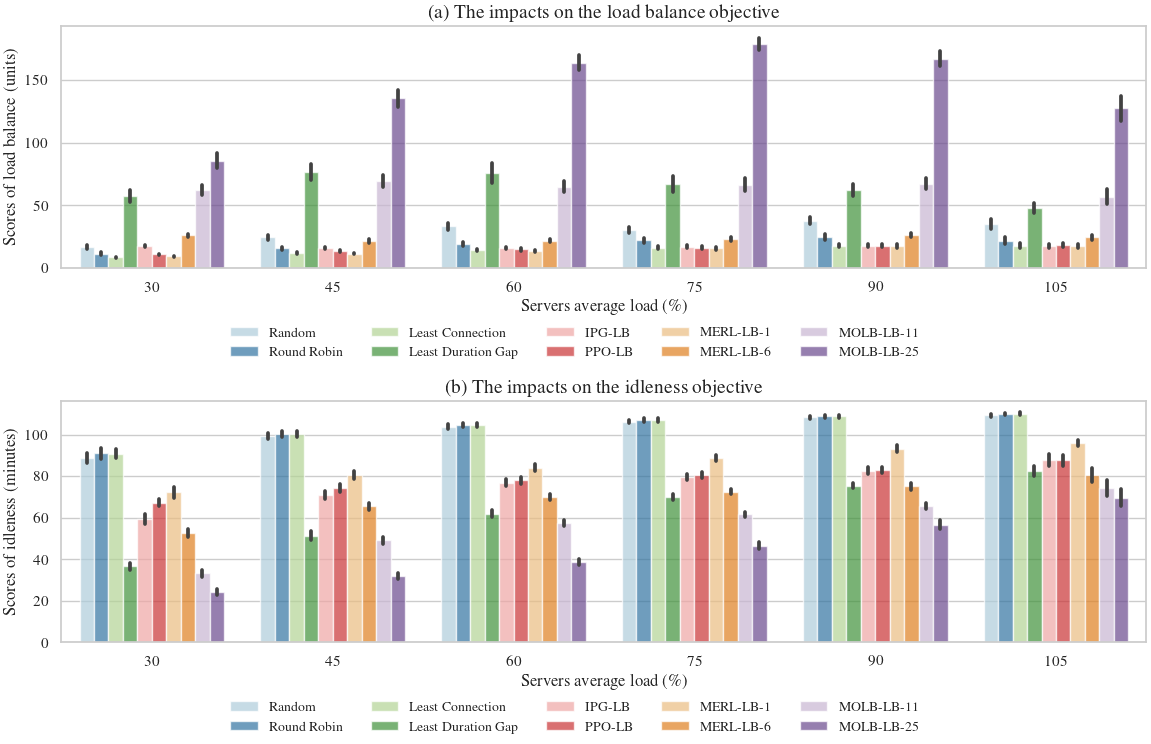

In [36]:
plt.figure(figsize=(14, 8))
ax = plt.subplot(2, 1, 1)
plt.subplots_adjust(hspace=0.55)
sns.barplot(
    data=df4, 
    x="Average load", y="Score", hue="Method",
    errorbar="sd", alpha=0.7, palette="Paired", ax = ax
)
plt.ylabel('Scores of load balance (units)')
plt.xlabel('Servers average load (\%)')
# plt.subplots_adjust(hspace=0.4, wspace=0.1)
plt.title(f'(a) The impacts on the load balance objective', fontsize = 14)
plt.legend(loc=(0.15, -0.4), ncol=5, prop={'size': 10})
# plt.savefig('时长随负载变化图2.pdf', dpi=300, bbox_inches = 'tight')

ax = plt.subplot(2, 1, 2)
sns.barplot(
    data=df5, 
    x="Average load", y="Score", hue="Method",
    errorbar="sd", alpha=0.7, palette="Paired", ax = ax
)
plt.ylabel('Scores of idleness (minutes)')
plt.xlabel('Servers average load (\%)')
# plt.subplots_adjust(hspace=0.4, wspace=0.1)
plt.title(f'(b) The impacts on the idleness objective', fontsize = 14)
plt.legend(loc=(0.15, -0.4), ncol=5, prop={'size': 10})
plt.savefig('3-平均均衡随负载变化对比图.png', dpi=300, bbox_inches = 'tight')

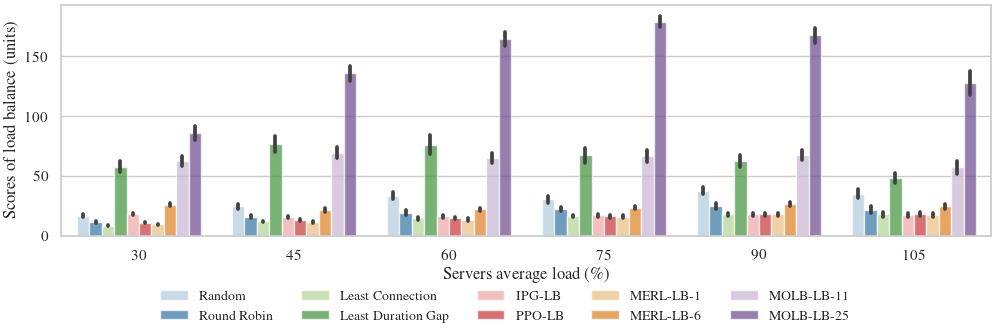

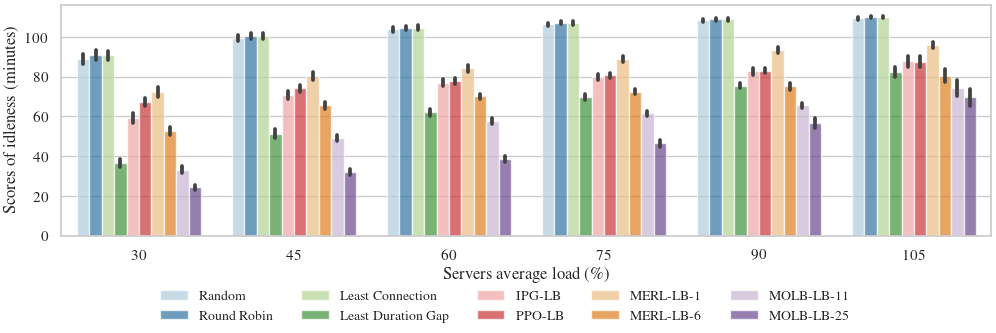

In [37]:
plt.figure(figsize=(12, 3))
ax = plt.subplot(1, 1, 1)
sns.barplot(
    data=df4, 
    x="Average load", y="Score", hue="Method",
    errorbar="sd", alpha=0.7, palette="Paired", ax = ax
)
plt.ylabel('Scores of load balance (units)')
plt.xlabel('Servers average load (\%)')
plt.legend(loc=(0.1, -0.4), ncol=5, prop={'size': 10})
plt.savefig('3-平均均衡随负载变化对比图-1.pdf', dpi=300, bbox_inches = 'tight')

plt.figure(figsize=(12, 3))
ax = plt.subplot(1, 1, 1)
sns.barplot(
    data=df5, 
    x="Average load", y="Score", hue="Method",
    errorbar="sd", alpha=0.7, palette="Paired", ax = ax
)
plt.ylabel('Scores of idleness (minutes)')
plt.xlabel('Servers average load (\%)')
plt.legend(loc=(0.1, -0.4), ncol=5, prop={'size': 10})
plt.savefig('3-平均均衡随负载变化对比图-2.pdf', dpi=300, bbox_inches = 'tight')

In [6]:
# 负载影响
save_path = {
    'Random':'output/test/rd/server_num_test01',
    'Round Robin':'output/test/rr/server_num_test01',
    'Least Connection':'output/test/lc/server_num_test01',
    'Least Duration Gap':'output/test/lg/server_num_test01',
    'MOLB-IPG':'output/test/igd/server_num_test01',
    'MOLB-PPO':'output/test/ppo/server_num_test01',
    'MERL-LB-1':'output/test/nei_nsga/server_num_test01-1',
    'MERL-LB-6':'output/test/nei_nsga/server_num_test01-6',
    'MOLB-LB-11':'output/test/nei_nsga/server_num_test01-11',
    'MOLB-LB-25':'output/test/nei_nsga/server_num_test01-25',
}
load_list = [5,10,20,30,40,50]

def get_all_rate(path, num=50):
    data = []
    for i in range(num):
        file_path = os.path.join(path, f'occupancy_rate_{i}.npy')
        data.append(np.load(file_path))
    return np.array(data)

data = []
for key, item_path in save_path.items():
    for load in load_list:
        final_path = f'{item_path}/server_num_{load}/data'
        item_data = get_all_rate(final_path)

        _score = []
        for item in item_data:
            item_score = np.array(item) * 500
            item_score = np.mean(np.std(item_score, axis=-2))
            _score.append(item_score)
        _method = [key] * len(_score)
        _load = [load] * len(_score)
        _item_data = zip(_method, _load,  _score)
        _item_df = pd.DataFrame(_item_data, columns=['Method', 'Server num', 'Score'])
        data.append(_item_df)

df6 = pd.concat(data, axis=0)

In [7]:
# 负载影响
save_path = {
    'Random':'output/test/rd/server_num_test01',
    'Round Robin':'output/test/rr/server_num_test01',
    'Least Connection':'output/test/lc/server_num_test01',
    'Least Duration Gap':'output/test/lg/server_num_test01',
    'MOLB-IPG':'output/test/igd/server_num_test01',
    'MOLB-PPO':'output/test/ppo/server_num_test01',
    'MERL-LB-1':'output/test/nei_nsga/server_num_test01-1',
    'MERL-LB-6':'output/test/nei_nsga/server_num_test01-6',
    'MOLB-LB-11':'output/test/nei_nsga/server_num_test01-11',
    'MOLB-LB-25':'output/test/nei_nsga/server_num_test01-25',
}
load_list = [10,20,30,40,50]

def get_all_rate(path, num=50):
    data = []
    for i in range(num):
        file_path = os.path.join(path, f'occupancy_rate_{i}.npy')
        data.append(np.load(file_path))
    return np.array(data)

data = []
for key, item_path in save_path.items():
    for load in load_list:
        final_path = f'{item_path}/server_num_{load}/data'
        item_data = get_all_rate(final_path)

        _score = []
        for item in item_data:
            item_score = np.array(item) * 500
            item_score = np.mean(np.std(item_score, axis=-2))
            _score.append(item_score)
        _method = [key] * len(_score)
        _load = [load] * len(_score)
        _item_data = zip(_method, _load,  _score)
        _item_df = pd.DataFrame(_item_data, columns=['Method', 'Server num', 'Score'])
        data.append(_item_df)

df6 = pd.concat(data, axis=0)

In [8]:
import numpy as np
# 负载影响
save_path = {
    'Random':'output/test/rd/server_num_test01',
    'Round Robin':'output/test/rr/server_num_test01',
    'Least Connection':'output/test/lc/server_num_test01',
    'Least Duration Gap':'output/test/lg/server_num_test01',
    'MOLB-IPG':'output/test/igd/server_num_test01',
    'MOLB-PPO':'output/test/ppo/server_num_test01',
    'MERL-LB-1':'output/test/nei_nsga/server_num_test01-1',
    'MERL-LB-6':'output/test/nei_nsga/server_num_test01-6',
    'MOLB-LB-11':'output/test/nei_nsga/server_num_test01-11',
    'MOLB-LB-25':'output/test/nei_nsga/server_num_test01-25',
}
load_list = [10,20,30,40,50]
score_list = ['CPU', 'RAM', 'HDD', 'BW']

def get_finish(path, num=50):
    data = []
    for i in range(num):
        file_path = os.path.join(path, f'finish_time_{i}.npy')
        data.append(np.load(file_path))
    return np.array(data)

data = []
for key, item_path in save_path.items():
    for load in load_list:
        final_path = f'{item_path}/server_num_{load}/data'
        item_data = get_finish(final_path)
        _score = []
        for item in item_data:
            item_score = np.array(item)
            item_score = np.mean(item_score)
            _score.append(item_score/5)
        _method = [key] * len(_score)
        _load = [load] * len(_score)
        _score_type = ['Idle'] * len(_score)
        _item_data = zip(_method, _load, _score_type,  _score)
        _item_df = pd.DataFrame(_item_data, columns=['Method', 'Server num',  'Score type', 'Score'])
        data.append(_item_df)

df7 = pd.concat(data, axis=0)

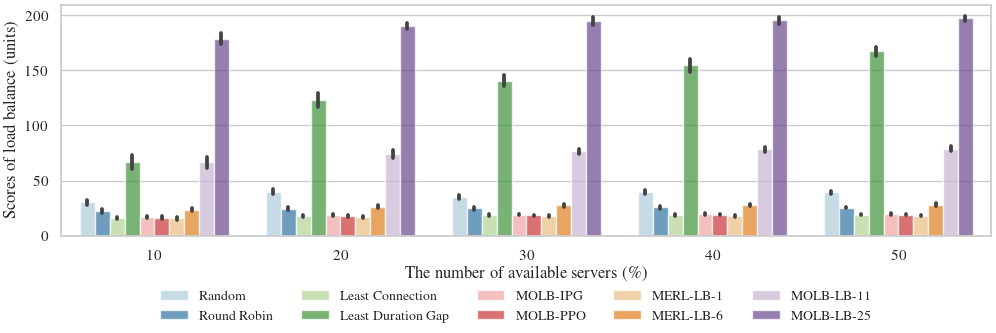

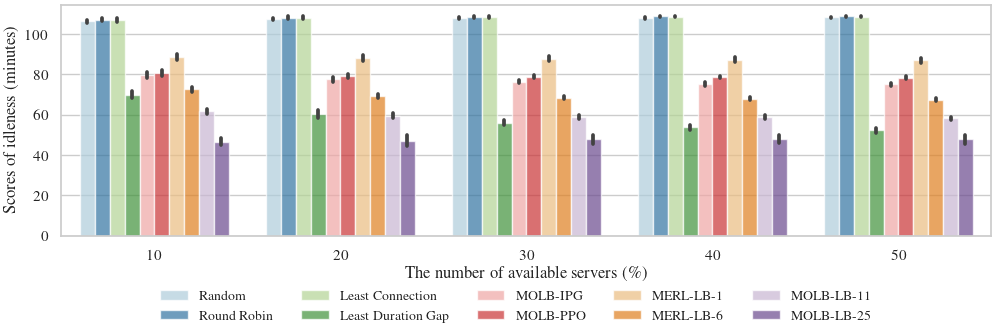

In [9]:
plt.figure(figsize=(12, 3))
ax = plt.subplot(1, 1, 1)
sns.barplot(
    data=df6, 
    x="Server num", y="Score", hue="Method",
    errorbar="sd", alpha=0.7, palette="Paired", ax = ax
)
plt.ylabel('Scores of load balance (units)')
plt.xlabel('The number of available servers (\%)')
plt.legend(loc=(0.1, -0.4), ncol=5, prop={'size': 10})
plt.savefig('3-随服务器数量变化对比-1.pdf', dpi=300, bbox_inches = 'tight')

plt.figure(figsize=(12, 3))
ax = plt.subplot(1, 1, 1)
sns.barplot(
    data=df7, 
    x="Server num", y="Score", hue="Method",
    errorbar="sd", alpha=0.7, palette="Paired", ax = ax
)
plt.ylabel('Scores of idleness (minutes)')
plt.xlabel('The number of available servers (\%)')
plt.legend(loc=(0.1, -0.4), ncol=5, prop={'size': 10})
plt.savefig('3-随服务器数量变化对比-2.pdf', dpi=300, bbox_inches = 'tight')

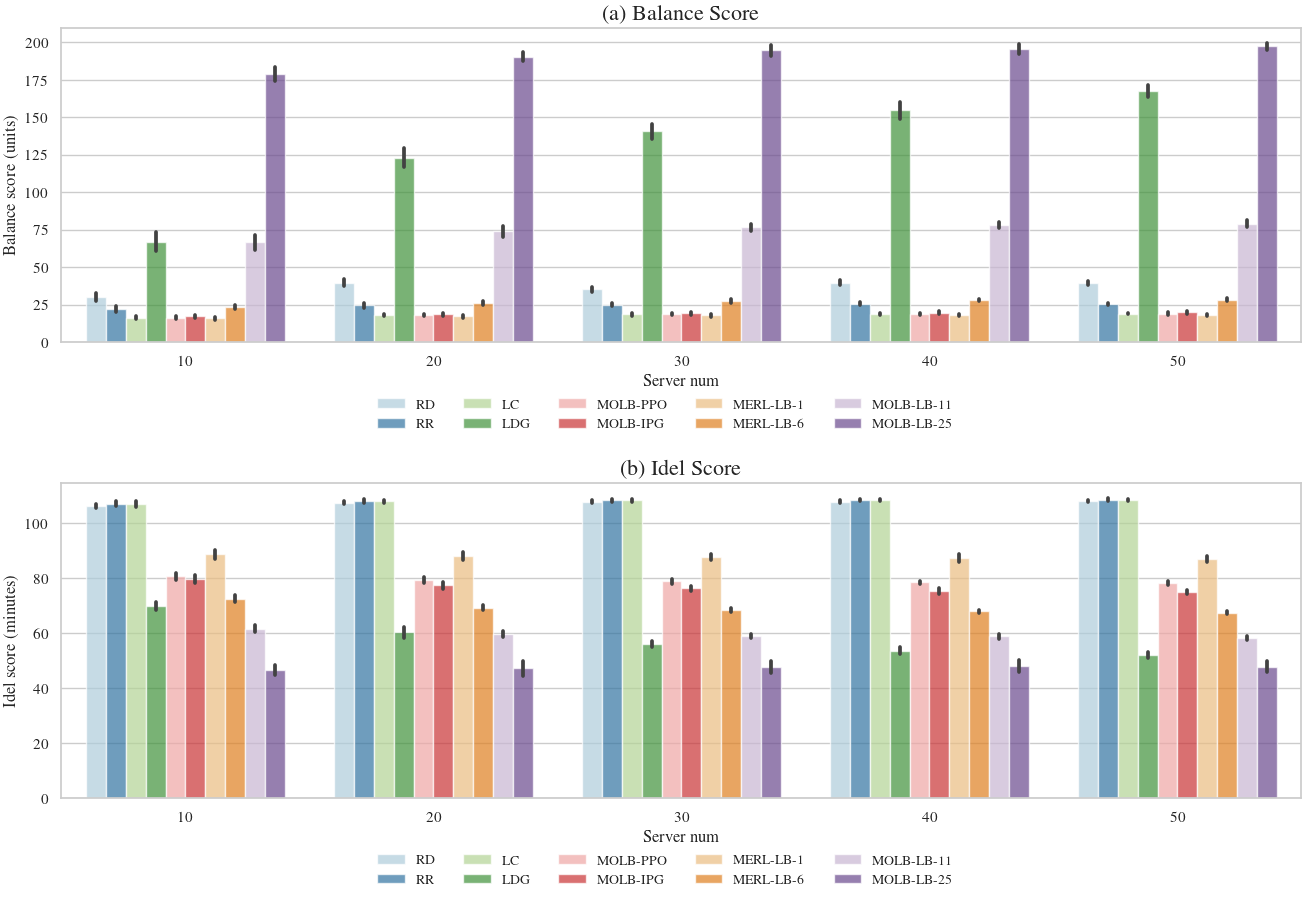

In [8]:
plt.figure(figsize=(16, 10))
ax = plt.subplot(2, 1, 1)
plt.subplots_adjust(hspace=0.45)
sns.barplot(
    data=df6, 
    x="Server num", y="Score", hue="Method",
    errorbar="sd", alpha=0.7, palette="Paired", ax = ax
)
plt.ylabel('Balance score (units)')
plt.xlabel('Server num')
# plt.subplots_adjust(hspace=0.4, wspace=0.1)
plt.title(f'(a) Balance Score', fontsize = 16)
plt.legend(loc=(0.25, -0.30), ncol=5, prop={'size': 10})
# plt.savefig('时长随负载变化图2.pdf', dpi=300, bbox_inches = 'tight')

ax = plt.subplot(2, 1, 2)
sns.barplot(
    data=df7, 
    x="Server num", y="Score", hue="Method",
    errorbar="sd", alpha=0.7, palette="Paired", ax = ax
)
plt.ylabel('Idel score (minutes)')
plt.xlabel('Server num')
# plt.subplots_adjust(hspace=0.4, wspace=0.1)
plt.title(f'(b) Idel Score', fontsize = 16)
plt.legend(loc=(0.25, -0.30), ncol=5, prop={'size': 10})
plt.savefig('随服务器数量变化对比2.pdf', dpi=300, bbox_inches = 'tight')

In [10]:
import pandas as pd
# 负载影响
save_path = {
    'Random':'output/test/rd/user_sigam_test01',
    'Round Robin':'output/test/rr/user_sigam_test01',
    'Least Connection':'output/test/lc/user_sigam_test01',
    'Least Duration Gap':'output/test/lg/user_sigam_test01',
    'MOLB-IPG':'output/test/igd/user_sigam_test01',
    'MOLB-PPO':'output/test/ppo/user_sigam_test01',
    'MERL-LB-1':'output/test/nei_nsga/user_sigam_test01-1',
    'MERL-LB-6':'output/test/nei_nsga/user_sigam_test01-6',
    'MOLB-LB-11':'output/test/nei_nsga/user_sigam_test01-11',
    'MOLB-LB-25':'output/test/nei_nsga/user_sigam_test01-25',
}
load_list = [0,30,60,90,120,150]

def get_all_rate(path, num=50):
    data = []
    for i in range(num):
        file_path = os.path.join(path, f'occupancy_rate_{i}.npy')
        data.append(np.load(file_path))
    return np.array(data)

data = []
for key, item_path in save_path.items():
    for load in load_list:
        final_path = f'{item_path}/user_sigma_{load}/data'
        item_data = get_all_rate(final_path)

        _score = []
        for item in item_data:
            item_score = np.array(item) * 500
            item_score = np.mean(np.std(item_score, axis=-2))
            _score.append(item_score)
        _method = [key] * len(_score)
        _load = [load//5] * len(_score)
        _item_data = zip(_method, _load,  _score)
        _item_df = pd.DataFrame(_item_data, columns=['Method', 'User sigma', 'Score'])
        data.append(_item_df)

df8 = pd.concat(data, axis=0)

In [11]:
import numpy as np
# 负载影响
save_path = {
    'Random':'output/test/rd/user_sigam_test01',
    'Round Robin':'output/test/rr/user_sigam_test01',
    'Least Connection':'output/test/lc/user_sigam_test01',
    'Least Duration Gap':'output/test/lg/user_sigam_test01',
    'MOLB-IPG':'output/test/igd/user_sigam_test01',
    'MOLB-PPO':'output/test/ppo/user_sigam_test01',
    'MERL-LB-1':'output/test/nei_nsga/user_sigam_test01-1',
    'MERL-LB-6':'output/test/nei_nsga/user_sigam_test01-6',
    'MOLB-LB-11':'output/test/nei_nsga/user_sigam_test01-11',
    'MOLB-LB-25':'output/test/nei_nsga/user_sigam_test01-25',
}
load_list = [0,30,60,90,120,150]
score_list = ['CPU', 'RAM', 'HDD', 'BW']

def get_finish(path, num=50):
    data = []
    for i in range(num):
        file_path = os.path.join(path, f'finish_time_{i}.npy')
        data.append(np.load(file_path))
    return np.array(data)

data = []
for key, item_path in save_path.items():
    for load in load_list:
        final_path = f'{item_path}/user_sigma_{load}/data'
        item_data = get_finish(final_path)
        _score = []
        for item in item_data:
            item_score = np.array(item)
            item_score = np.mean(item_score)
            _score.append(item_score/5)
        _method = [key] * len(_score)
        _load = [load//5] * len(_score)
        _score_type = ['Idle'] * len(_score)
        _item_data = zip(_method, _load, _score_type,  _score)
        _item_df = pd.DataFrame(_item_data, columns=['Method', 'User sigma',  'Score type', 'Score'])
        data.append(_item_df)

df9 = pd.concat(data, axis=0)

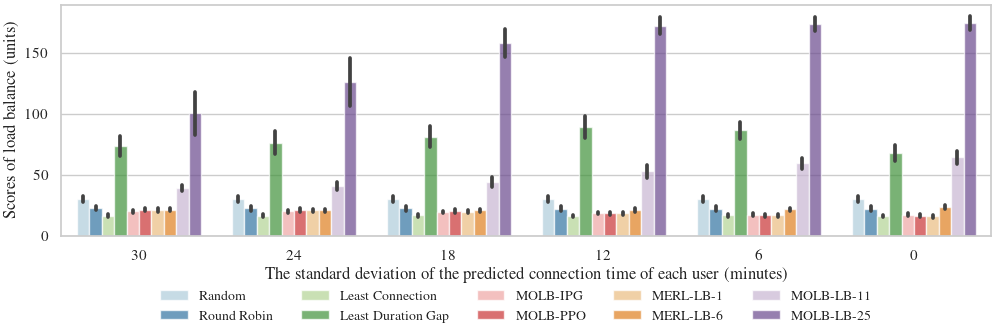

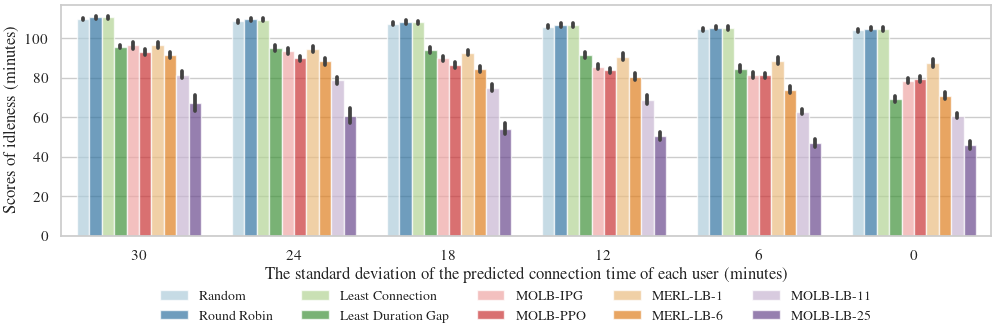

In [12]:
plt.figure(figsize=(12, 3))
ax = plt.subplot(1, 1, 1)
order_list = [30,24,18,12,6,0]
sns.barplot(
    data=df8, 
    x="User sigma", y="Score", hue="Method",
    errorbar="sd", alpha=0.7, palette="Paired", ax = ax, order=order_list
)
plt.ylabel('Scores of load balance (units)')
plt.xlabel('The standard deviation of the predicted connection time of each user (minutes)')
plt.legend(loc=(0.1, -0.4), ncol=5, prop={'size': 10})
plt.savefig('3-随用户可预测性变化对比图-1-1.pdf', dpi=300, bbox_inches = 'tight')

plt.figure(figsize=(12, 3))
ax = plt.subplot(1, 1, 1)
sns.barplot(
    data=df9, 
    x="User sigma", y="Score", hue="Method",
    errorbar="sd", alpha=0.7, palette="Paired", ax = ax, order=order_list
)
plt.ylabel('Scores of idleness (minutes)')
plt.xlabel('The standard deviation of the predicted connection time of each user (minutes)')
plt.legend(loc=(0.1, -0.4), ncol=5, prop={'size': 10})
plt.savefig('3-随用户可预测性变化对比图-2.pdf', dpi=300, bbox_inches = 'tight')

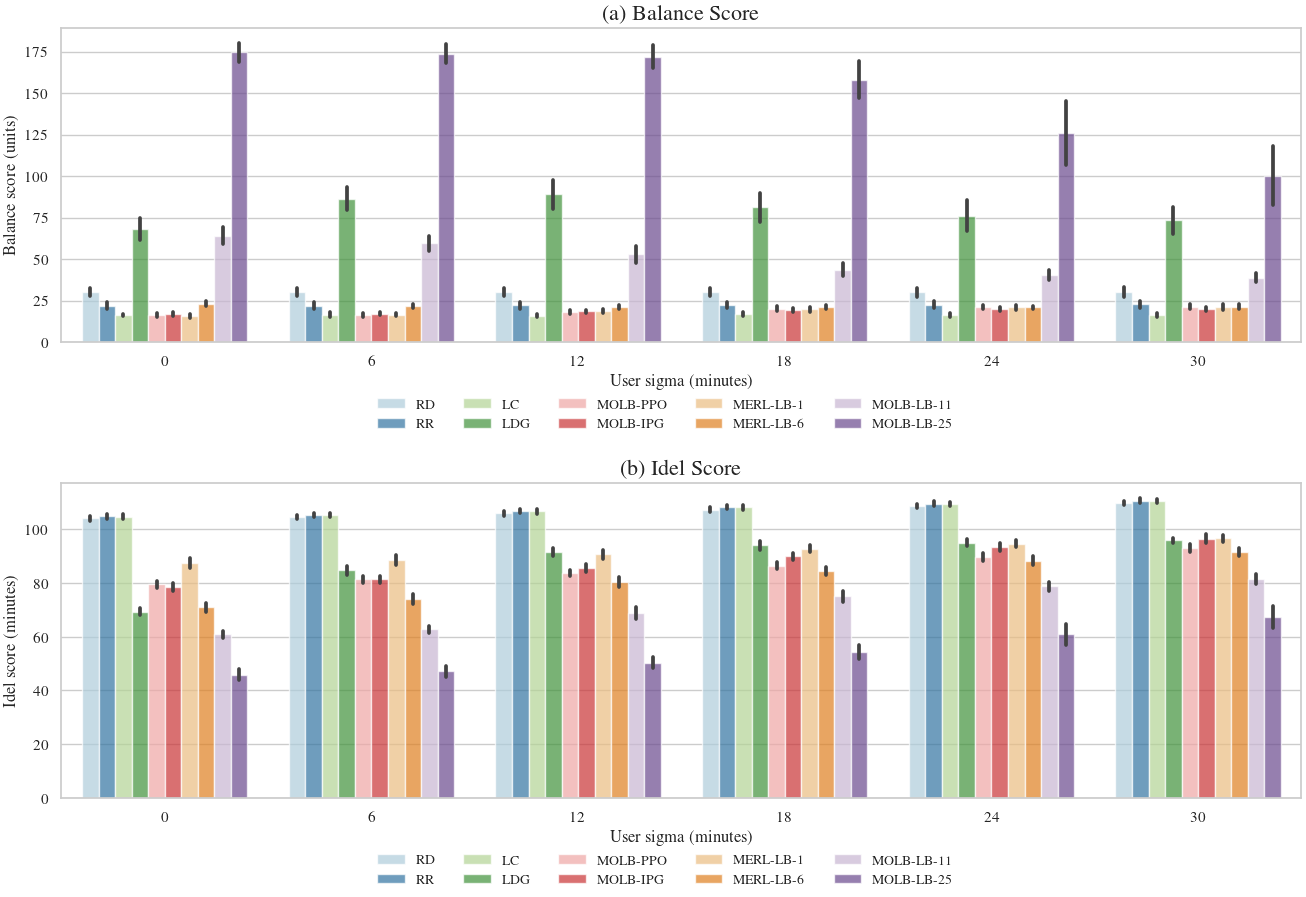

In [15]:
plt.figure(figsize=(16, 10))
ax = plt.subplot(2, 1, 1)
plt.subplots_adjust(hspace=0.45)
sns.barplot(
    data=df8, 
    x='User sigma', y="Score", hue="Method",
    errorbar="sd", alpha=0.7, palette="Paired", ax = ax
)
plt.ylabel('Balance score (units)')
plt.xlabel('User sigma (minutes)')
# plt.subplots_adjust(hspace=0.4, wspace=0.1)
plt.title(f'(a) Balance Score', fontsize = 16)
plt.legend(loc=(0.25, -0.30), ncol=5, prop={'size': 10})
# plt.savefig('时长随负载变化图2.pdf', dpi=300, bbox_inches = 'tight')

ax = plt.subplot(2, 1, 2)
sns.barplot(
    data=df9, 
    x='User sigma', y="Score", hue="Method",
    errorbar="sd", alpha=0.7, palette="Paired", ax = ax
)
plt.ylabel('Idel score (minutes)')
plt.xlabel('User sigma (minutes)')
# plt.subplots_adjust(hspace=0.4, wspace=0.1)
plt.title(f'(b) Idel Score', fontsize = 16)
plt.legend(loc=(0.25, -0.30), ncol=5, prop={'size': 10})
plt.savefig('随用户可预测性变化对比图.pdf', dpi=300, bbox_inches = 'tight')